<a href="https://colab.research.google.com/github/Tianze1992/CPlusPlusThings/blob/master/Objective_function_behavior_simple_structure_FFTZ_GP_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Google Colab


In [ ]:
import sys
import torch
print(sys.version)

print("----------------")
!python --version
print("----------------")
!nvcc --version

print("----------------")

print("torch.cuda.is_available: ",torch.cuda.is_available())
print("----------------")
print(torch.cuda.get_device_name(0))
print("----------------")
print(torch.__version__)
!nvidia-smi

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Implicit_FWI

3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
----------------
Python 3.7.14
----------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
----------------
torch.cuda.is_available:  True
----------------
Tesla V100-SXM2-16GB
----------------
1.12.1+cu113
Sun Sep 18 00:41:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+============

In [ ]:
pip install Rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 8.2 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
from rich.progress import track
import  time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def add_colorbar(ax, im, bbox_transform, #ax.transAxes
                 width="5%", 
                 height="100%",
                 loc='lower left',
                 bbox_to_anchor=(1.01, 0., 1, 1),
                 borderpad=0,
                 ctitle=''):
    axins = inset_axes(ax,
                       width=width, 
                       height=height,
                       loc=loc,
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=bbox_transform,
                       borderpad=borderpad)
    cbar = plt.colorbar(im, cax=axins)
    axins.set(title=ctitle)
    return cbar
    
def imagesc(fig,
            images,
            vmin=1.5,
            vmax=4.5,
            extent=[0, 1.01, 1.01, 0],
            aspect=1,
            nRows_nCols=(1, 1),
            cmap='coolwarm',
            ylabel="Depth (km)",
            xlabel="Position (km)",
            clabel="km/s",
            fontsize=2,
            xticks=np.arange(0., 1.01, 0.4),
            yticks=np.arange(0., 1.01, 0.4),
            cbar_width="5%",
            cbar_height="100%",
            cbar_loc='lower left',
            cbar_mode="corner",
            bbox_to_anchor=(1.05, 0., 1, 1.),
            ):
    (nrow, ncol) = nRows_nCols
    if not isinstance(vmin, (list, tuple, np.ndarray)) or not isinstance(vmax, (list, tuple, np.ndarray)):
        vmin = [vmin] * nrow
        vmax = [vmax] * nrow
    
    gs = fig.add_gridspec(nrow, ncol)
    for irow in range(nrow):
        for icol in range(ncol):
            ax = fig.add_subplot(gs[irow, icol])
            #print("irow and icol", irow, icol)
            #print(images[irow, icol].shape)
            im = ax.imshow(images[irow, icol], 
                           vmin=vmin[irow], vmax=vmax[irow], 
                           extent=extent,
                           aspect=aspect,
                           cmap=cmap)
            if icol == 0:
                ax.set_ylabel(ylabel, fontsize=fontsize)
                if yticks is not None:
                    ax.set_yticks(yticks)
            else:
                ax.set_yticks([])
            if irow == nrow - 1:
                ax.set_xlabel(xlabel, fontsize=fontsize)
                if xticks is not None:
                    ax.set_xticks(xticks)
            else:
                ax.set_xticks([])
            ax.tick_params(axis='both', labelsize=fontsize, which='major', pad=0.1)

            cbar_plot = False
            if cbar_mode == 'corner' and (irow == nrow-1 and icol == ncol-1):
                cbar_plot = True
            elif cbar_mode =='row' and (icol == ncol-1):
                cbar_plot = True
            elif cbar_mode == 'each':
                cbar_plot = True
            if cbar_plot is True:
                axins = inset_axes(ax,
                               width=cbar_width, 
                               height=cbar_height,
                               loc=cbar_loc,
                               bbox_to_anchor=bbox_to_anchor,
                               bbox_transform=ax.transAxes,
                               borderpad=0,
                               )
                axins.tick_params(axis='both', labelsize=fontsize, which='major', pad=0.1)
                cbar = plt.colorbar(im, cax=axins)
                cbar.ax.set_ylabel(clabel, fontsize=fontsize)
    return

true vp model shape is  torch.Size([50, 50])
init vp model shape is  torch.Size([50, 50])
true vs model shape is  torch.Size([50, 50])
init vs model shape is  torch.Size([50, 50])
this is nz 50
this is nx 50
model size: [50, 50]


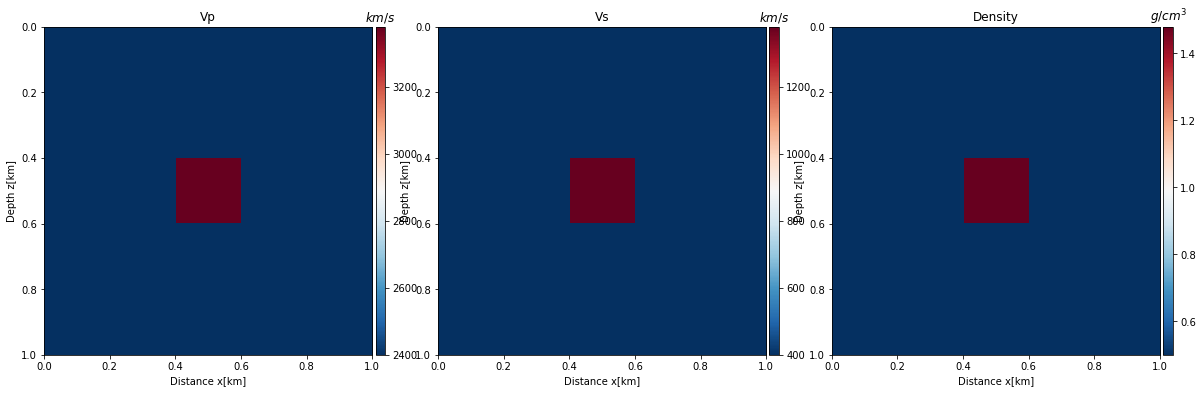

In [ ]:
# loading data
vp_true = torch.ones(50,50)*2400
vs_true = torch.ones(50,50)*400
rho_true = torch.ones(50,50)*0.5



vp_true[20:30,20:30] = 3380;
#vp_true[60:,  :] = 3000;

vs_true[20:30,20:30] = 1380;
#vs_true[60:,  :] = 2500;

rho_true[20:30,20:30] = 1.48;
#rho_true[60:,  :] = 1.5;

#vp_init  = torch.ones(100,100)*2000
#vs_init  = torch.ones(100,100)*1400
#rho_init = torch.ones(100,100)*1



vp_init  = vp_true
vs_init  = vs_true
rho_init  = rho_true


print("true vp model shape is ", vp_true.shape)
print("init vp model shape is ", vp_init.shape)
print("true vs model shape is ", vs_true.shape)
print("init vs model shape is ", vs_init.shape)



dx0 = 20
dz0 = 20
[nz, nx] = [vp_true.shape[0],vp_true.shape[1]]

#rho_true = np.ones([nz,nx])*2
#rho_true = torch.as_tensor(rho_true)
#rho_init = torch.as_tensor(rho_true)


print("this is nz",nz)
print("this is nx",nx)
x = np.arange(0, nx, dtype=np.float32)*dx0
z = np.arange(0, nz, dtype=np.float32)*dz0
vMin=np.amin(vp_true.clone().detach().numpy())
vMax=500

print("model size: [{}, {}]".format(nz,nx))


vp_tensor = torch.as_tensor(vp_true).type(dtype=torch.float32).to(device)
vs_tensor = torch.as_tensor(vs_true).type(dtype=torch.float32).to(device)
rho_tensor = torch.as_tensor(rho_true).type(dtype=torch.float32).to(device)

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')


ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')

ax = fig.add_subplot(gs[0, 2])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Density")
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$g/cm^3$')

# 1. Velocity loading and forward modeling check ...

tensor(0.4780, device='cuda:0') < 1
tensor(0.8000, device='cuda:0') > 1


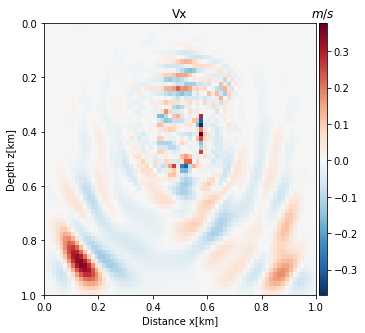

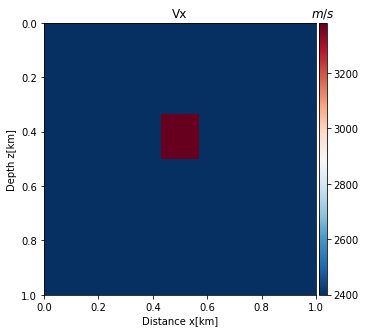

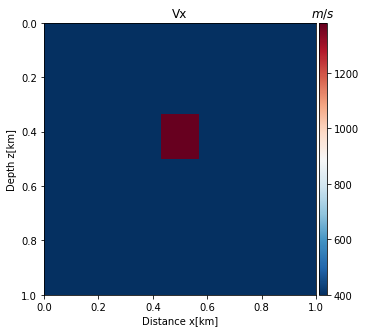

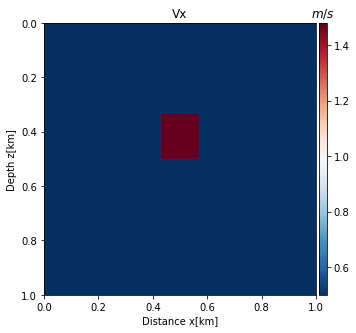

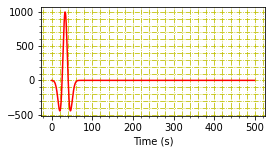

In [ ]:
from rnn_fd_elastic_4order import rnn2D
from generator import wGenerator
sample_interval = 30
freeSurface = False                                                      # free surface option for forward modeling
npad = 10                                                               # velocity padding in grid points
freq = 15.0                                                             # dominant frequency of wavelet in Hz
dt = 0.002                                                             # time samling interval, fixed for all shots gathers
nt = 500                                                                # number of samples in time
nv = 1 
vp_tensor = vp_true
vs_tensor = vs_true
rho_tensor = rho_true
nz, nx = vp_tensor.shape

xs = np.arange(2,nx,10,dtype=np.int32) # source x-coordinate
zs = np.ones(xs.shape, dtype=np.int32) # source z-coordinate


xr = np.arange(0,nx, 1, dtype=np.int32) # receiver x-coordinate
zr = np.ones(xr.shape, dtype=np.int32) # receiver z-coordinate


t = dt * torch.arange(0, nt, dtype=torch.float32)                       # create time vector
wavelet = wGenerator(t, freq).ricker().to(device)*1000                       # generate wavelet
nx_pad = nx + 2 * npad
nz_pad = nz + npad if freeSurface else nz + 2 * npad
dx = 20
dz = 20

vp_tensor = torch.reshape(vp_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
vs_tensor = torch.reshape(vs_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
rho_tensor = torch.reshape(rho_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)


'''
vmodel = torch.cat((vp_tensor,vs_tensor,rho_tensor),dim=0)
print("this is the shape ", vmodel[0,:,:,].shape)
'''


################## Check the stability condition #################
print(vp_tensor.max()*dt/dz/np.sqrt(1/2),"< 1") # should <1
print(vp_tensor.min()/10/freq/dz,"> 1") # should >1


forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=4, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)

vp_mean = vp_tensor.mean()
vp_std  = vp_tensor.std()

vs_mean = vs_tensor.mean()
vs_std  = vs_tensor.std()

rho_mean = rho_tensor.mean()
rho_std  = rho_tensor.std()



# forward modeling
vx_save, vz_save, \
txx_save, tzz_save, txz_save, \
segment_ytPred_x,segment_ytPred_z,avg_regularizer,\
vp_tensor_out,vs_tensor_out,rho_tensor_out = \
forward_rnn(vp_tensor=vp_tensor.to(device),\
            vs_tensor=vs_tensor.to(device),\
            rho_tensor=rho_tensor.to(device),\
            segment_wavelet=wavelet)


fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vx")
im = ax.imshow(vx_save[:,1,:,:].squeeze().cpu(), extent=[0, nx*dx/1000, nz*dz/1000, 0], \
               aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$') 

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vx")
im = ax.imshow(vp_tensor_out.squeeze().cpu(), extent=[0, nx*dx/1000, nz*dz/1000, 0], \
               aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$')  

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vx")
im = ax.imshow(vs_tensor_out.squeeze().cpu(), extent=[0, nx*dx/1000, nz*dz/1000, 0], \
               aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$') 

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vx")
im = ax.imshow(rho_tensor_out.squeeze().cpu(), extent=[0, nx*dx/1000, nz*dz/1000, 0], \
               aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$') 


fig = plt.figure(figsize=(4,2))
plt.plot(wavelet.cpu().numpy(),'r'),plt.xlabel('Time (s)')
plt.grid(True, which='both', linestyle = '-.', color='y'),plt.minorticks_on()
plt.show()


torch.Size([5, 500, 50])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


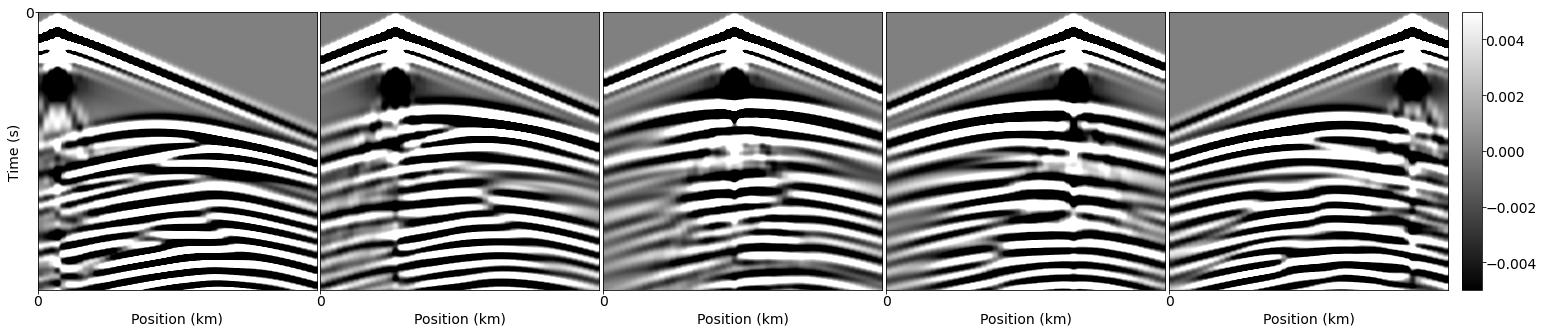

In [ ]:
print(segment_ytPred_z.shape)
fig=plt.figure(figsize=(20, 6))
imagesc(fig,
        segment_ytPred_z.cpu().numpy().reshape(-1, 5, len(t), len(xr)),
        vmin=-segment_ytPred_z.max()/100,
        vmax=segment_ytPred_z.max()/100,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=1, #5
        nRows_nCols=(1, 5),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=14,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')
fig.tight_layout(pad=-.05)

In [ ]:
pip install Rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shots_true= torch.cat((segment_ytPred_x.reshape(1, len(xs),len(t), len(xr)),\
                  segment_ytPred_z.reshape(1, len(xs),len(t), len(xr))),dim=0)
print(shots_true.shape)
model_variation_step = 50

torch.Size([2, 5, 500, 50])


In [ ]:
import torch.nn as nn
class LogLoss(nn.Module):
    def __init__(self,t, loss_scale):
        super(LogLoss,self).__init__()
        t_size=t
        print("using log information as misfit")
        d_t_max = t_size
        self.t_lenth = t_size
        
        self.FFT_kernel_real = np.ones((d_t_max,d_t_max))
        self.FFT_kernel_imag = np.ones((d_t_max,d_t_max))

        for i in range(d_t_max):
            for j in range(d_t_max):
                self.FFT_kernel_real[i,j] = (loss_scale**(-j))*np.cos((-2*np.pi*i*j)/d_t_max)
                self.FFT_kernel_imag[i,j] = (loss_scale**(-j))*np.sin((-2*np.pi*i*j)/d_t_max)
        self.FFT_kernel_real = torch.as_tensor(self.FFT_kernel_real,dtype = torch.float32).to(device)
        self.FFT_kernel_imag = torch.as_tensor(self.FFT_kernel_imag,dtype = torch.float32).to(device)

    def forward(self,shot_pre_comb,shot_true_comb):
        [num_batch, num_shot, num_nt, num_nr] = \
        [shot_pre_comb.shape[0],shot_pre_comb.shape[1],shot_pre_comb.shape[2],shot_pre_comb.shape[3]]

        loss = 0

        FFT_amplitude_true = torch.zeros(num_shot,num_nt,num_nr)
        FFT_phase_true     = torch.zeros(num_shot,num_nt,num_nr)

        FFT_amplitude_pred = torch.zeros(num_shot,num_nt,num_nr)
        FFT_phase_pred     = torch.zeros(num_shot,num_nt,num_nr)
        for ibatch in range(num_batch):
          for ishot in range (num_shot):
              i_shot_true =  shot_true_comb[ibatch, ishot,:,:]
              i_shot_pred =  shot_pre_comb [ibatch, ishot,:,:]
              for i_r in range(num_nr):
                  i_line_true = i_shot_true[:,i_r]
                  i_line_pred = i_shot_pred[:,i_r]
                  i_line_true = torch.reshape(torch.as_tensor(i_line_true,dtype = torch.float32),(num_nt,1))
                  #print(self.FFT_kernel_real.shape)
                  #print(i_line_true.shape)
                  true_real =  torch.mm(self.FFT_kernel_real,i_line_true)
                  true_imag =  torch.mm(self.FFT_kernel_imag,i_line_true)
                  
                  i_FFT_amplitude_true = \
                  (torch.pow(true_real,2) + torch.pow(true_imag,2)).squeeze() # give amplitude spectrum
                  i_FFT_phase_true     = \
                  (torch.arctan(true_imag/true_real)).squeeze()               # give phase     spectrum
                  
                  i_line_pred          =\
                  torch.reshape(torch.as_tensor(i_line_pred,dtype = torch.float32),(num_nt,1))
                  
                  pred_real            =  \
                  torch.mm(self.FFT_kernel_real,i_line_pred)
                  pred_imag            =  \
                  torch.mm(self.FFT_kernel_imag,i_line_pred)
                  
                  i_FFT_amplitude_true = \
                  (torch.pow(true_real,2) + torch.pow(true_imag,2)).squeeze() # give amplitude spectrum
                  i_FFT_phase_true     = \
                  (torch.atan2(true_imag,true_real)).squeeze()               # give phase     spectrum
                  
                  i_FFT_amplitude_pred = \
                  (torch.pow(pred_real,2) + torch.pow(pred_imag,2)).squeeze()
                  i_FFT_phase_pred     = \
                  (torch.atan2(pred_imag,pred_real)).squeeze()
                  
                  log_loss = (1/2)*((i_FFT_amplitude_true[:(self.t_lenth//2)]-i_FFT_amplitude_pred[:(self.t_lenth//2)]))**2
                  
                  loss = loss + torch.sum(log_loss)
                
        return i_FFT_amplitude_true,i_FFT_phase_true,i_FFT_amplitude_pred,i_FFT_phase_pred,loss

In [ ]:
class Envelope_based(torch.nn.Module):
  def __init__(self):
    print("Using the envelope based objective function")
 
  def forward(self,i_ter, shot_pre_comb, shot_true_comb):
    [num_batch, num_shot, num_nt, num_nr] = [shot_pre_comb.shape[0],shot_pre_comb.shape[1],shot_pre_comb.shape[2],shot_pre_comb.shape[3]]
    loss = 0
    if (i_ter <= 40):
      for ibatch in range(num_batch):
        for ishot in range (num_shot):
          i_shot_true =  shot_true_comb[ibatch, ishot,:,:]
          i_shot_pred =  shot_pre_comb [ibatch, ishot,:,:]
          for i_r in range(num_nr):
            i_line_true = i_shot_true[:,i_r]
            i_line_pred = i_shot_pred[:,i_r]
            #i_line_true = torch.reshape(torch.as_tensor(i_line_true,dtype = torch.float32),(num_nt,1))
            '''
            i_line_pred_fft = fx = torch.fft.fft(i_line_pred)
            i_line_pred_fft_h = i_line_pred_fft
            i_line_pred_fft_h[1: self.t//2] = 2 * i_line_pred_fft_h[1: self.t//2]
            i_line_pred_fft_h[self.t//2:] = 0
            i_line_pred_fft_hilbert = torch.fft.ifft(i_line_pred_fft_h).imag

            i_line_true_fft = fx = torch.fft.fft(i_line_true)
            i_line_true_fft_h = i_line_true_fft
            i_line_true_fft_h[1: self.t//2] = 2 * i_line_true_fft_h[1: self.t//2]
            i_line_true_fft_h[self.t//2:] = 0
            i_line_true_fft_hilbert = torch.fft.ifft(i_line_true_fft_h).imag

            i_line_pred_envelope = torch.abs(torch.fft.ifft(i_line_pred_fft_hilbert))
            i_line_true_envelope = torch.abs(torch.fft.ifft(i_line_true_fft_hilbert))
            '''
            i_line_pred_fft = torch.fft.rfft(i_line_pred)
            i_line_pred_fft_H = -1j*i_line_pred_fft
            i_line_pred_fft_H_inv = torch.fft.irfft(i_line_pred_fft_H)
            i_line_pred_envelope = torch.sqrt(i_line_pred**2 + i_line_pred_fft_H_inv**2 + 1e-30)

            i_line_true_fft = torch.fft.rfft(i_line_true)
            i_line_true_fft_H = -1j*i_line_true_fft
            i_line_true_fft_H_inv = torch.fft.irfft(i_line_true_fft_H)
            i_line_true_envelope = torch.sqrt(i_line_true**2 + i_line_true_fft_H_inv**2 + 1e-30)

            loss = loss + torch.sum((i_line_pred_envelope - i_line_true_envelope)**2 )

  return loss

In [ ]:
rho_true = torch.ones(50,50)*0.5
rho_true[20:30,20:30] = 1.48;
rho_tensor = torch.reshape(rho_true,(1,nz,nx)).type(dtype=torch.float32).to(device)



vp_init  = torch.ones(50,50)*2400
vs_init  = torch.ones(50,50)*400

vp_max = 2400 + 2000
vs_max = 400 + 2000
index = 0


vp_tensor_list = []
vs_tensor_list = []
x_list = []
y_list = []

for vp_variation in range (2400,vp_max,model_variation_step):
    for vs_variation in range (400,vs_max,model_variation_step):
        vp_init  = torch.ones(50,50)*2400
        vs_init  = torch.ones(50,50)*400
        vp_init[20:30,20:30] = vp_variation;
        #print(vp_init[20:30,20:30])
        vs_init[20:30,20:30] = vs_variation;

        vp_init = torch.reshape(vp_init,(1,nz,nx)).type(dtype=torch.float32).to(device)
        vs_init = torch.reshape(vs_init,(1,nz,nx)).type(dtype=torch.float32).to(device)

        vp_tensor_list.append(vp_init)
        vs_tensor_list.append(vs_init)
        x_list.append(vp_variation)
        y_list.append(vs_variation)

z_vp_vs_FFT_Z1_list = []

loss_func1          = LogLoss(500,1)

for step in track(range(len(vp_tensor_list))):
    vp_init = vp_tensor_list[step]
    vs_init = vs_tensor_list[step]

    forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=4, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)


    vx_save, vz_save, \
    txx_save, tzz_save, txz_save, \
    segment_ytPred_x_init,segment_ytPred_z_init,avg_regularizer,\
    vp_tensor_out,vs_tensor_out,rho_tensor_out = \
    forward_rnn(\
    vp_tensor = vp_init,\
    vs_tensor = vs_init,\
    rho_tensor= rho_tensor,\
    segment_wavelet=wavelet)
    shots_init= torch.cat((segment_ytPred_x_init.reshape(1, len(xs),len(t), len(xr)),segment_ytPred_z_init.reshape(1, len(xs),len(t), len(xr))),dim=0)
    
    A,B,C,D,loss_FFT_Z1 = loss_func1(shots_init, shots_true)
    print(loss_FFT_Z1)
    z_vp_vs_FFT_Z1_list.append(loss_FFT_Z1)



        

using log information as misfit


Output()

tensor(24505.7656, device='cuda:0')

tensor(24263.2773, device='cuda:0')

tensor(23739.6211, device='cuda:0')

tensor(25227.9355, device='cuda:0')

tensor(25118.7070, device='cuda:0')

tensor(24967.6035, device='cuda:0')

tensor(24623.6504, device='cuda:0')

tensor(23484.5879, device='cuda:0')

tensor(24701.1309, device='cuda:0')

tensor(26690.0723, device='cuda:0')

tensor(29076.7734, device='cuda:0')

tensor(30764.0957, device='cuda:0')

tensor(30286.2324, device='cuda:0')

tensor(34961.5781, device='cuda:0')

tensor(37317.5859, device='cuda:0')

tensor(39001.3398, device='cuda:0')

tensor(42595.4688, device='cuda:0')

tensor(44340.1562, device='cuda:0')

tensor(45195.9219, device='cuda:0')

tensor(43711.0547, device='cuda:0')

tensor(41000.5508, device='cuda:0')

tensor(42013.0547, device='cuda:0')

tensor(46127.9336, device='cuda:0')

tensor(50720.5156, device='cuda:0')

tensor(55896.1836, device='cuda:0')

tensor(61221.3477, device='cuda:0')

tensor(64695.9844, device='cuda:0')

tensor(65621.2812, device='cuda:0')

tensor(63716.5859, device='cuda:0')

tensor(59150.4102, device='cuda:0')

tensor(53153.0859, device='cuda:0')

tensor(47520.4453, device='cuda:0')

tensor(43317.3086, device='cuda:0')

tensor(40097.9609, device='cuda:0')

tensor(38171.8164, device='cuda:0')

tensor(40030.9648, device='cuda:0')

tensor(39060.7773, device='cuda:0')

tensor(32297.0820, device='cuda:0')

tensor(40514.7969, device='cuda:0')

tensor(41172.7930, device='cuda:0')

tensor(24327.7559, device='cuda:0')

tensor(24064.9316, device='cuda:0')

tensor(23521.3516, device='cuda:0')

tensor(25022.6621, device='cuda:0')

tensor(24886.4551, device='cuda:0')

tensor(24696.0273, device='cuda:0')

tensor(24252.3770, device='cuda:0')

tensor(23136.7031, device='cuda:0')

tensor(24288.8828, device='cuda:0')

tensor(26181.6816, device='cuda:0')

tensor(28342.3223, device='cuda:0')

tensor(29560.4043, device='cuda:0')

tensor(28957.2148, device='cuda:0')

tensor(33359.0547, device='cuda:0')

tensor(35664.6914, device='cuda:0')

tensor(37725.0820, device='cuda:0')

tensor(41506.7930, device='cuda:0')

tensor(43469.3125, device='cuda:0')

tensor(44486.7188, device='cuda:0')

tensor(42410.2148, device='cuda:0')

tensor(38563.8242, device='cuda:0')

tensor(39191.7734, device='cuda:0')

tensor(43949.0078, device='cuda:0')

tensor(49865.2930, device='cuda:0')

tensor(56100.5430, device='cuda:0')

tensor(61282.1875, device='cuda:0')

tensor(64239.9922, device='cuda:0')

tensor(65370.4727, device='cuda:0')

tensor(64449.1484, device='cuda:0')

tensor(60855.7617, device='cuda:0')

tensor(55320.8008, device='cuda:0')

tensor(49376.1250, device='cuda:0')

tensor(44265.8672, device='cuda:0')

tensor(41236.0117, device='cuda:0')

tensor(40236.0430, device='cuda:0')

tensor(39212.0664, device='cuda:0')

tensor(39054.6445, device='cuda:0')

tensor(38869.8789, device='cuda:0')

tensor(31459.6738, device='cuda:0')

tensor(39499.0430, device='cuda:0')

tensor(23896.6328, device='cuda:0')

tensor(23602.0469, device='cuda:0')

tensor(23043.5781, device='cuda:0')

tensor(24546.7773, device='cuda:0')

tensor(24397.2266, device='cuda:0')

tensor(24170.9375, device='cuda:0')

tensor(23639.8066, device='cuda:0')

tensor(22555.5625, device='cuda:0')

tensor(23590.8555, device='cuda:0')

tensor(25381.9766, device='cuda:0')

tensor(27392.8984, device='cuda:0')

tensor(28150.5742, device='cuda:0')

tensor(27438.7285, device='cuda:0')

tensor(31536.5586, device='cuda:0')

tensor(33718.4141, device='cuda:0')

tensor(36142.3008, device='cuda:0')

tensor(40183.3320, device='cuda:0')

tensor(42359.5664, device='cuda:0')

tensor(43277.5898, device='cuda:0')

tensor(40381.5039, device='cuda:0')

tensor(35556.7109, device='cuda:0')

tensor(36120.3555, device='cuda:0')

tensor(41695.2695, device='cuda:0')

tensor(48784.8242, device='cuda:0')

tensor(55498.8750, device='cuda:0')

tensor(60249.1328, device='cuda:0')

tensor(62955.5312, device='cuda:0')

tensor(64682.2070, device='cuda:0')

tensor(65118.0898, device='cuda:0')

tensor(63052.8789, device='cuda:0')

tensor(58563.1680, device='cuda:0')

tensor(53086.4883, device='cuda:0')

tensor(47443.0312, device='cuda:0')

tensor(42157.8477, device='cuda:0')

tensor(38667.9297, device='cuda:0')

tensor(38813.6953, device='cuda:0')

tensor(39319.2109, device='cuda:0')

tensor(37577.5938, device='cuda:0')

tensor(38079.7656, device='cuda:0')

tensor(30963.3691, device='cuda:0')

tensor(23359.4121, device='cuda:0')

tensor(23026.5098, device='cuda:0')

tensor(22446.3281, device='cuda:0')

tensor(23946.6074, device='cuda:0')

tensor(23784.6348, device='cuda:0')

tensor(23526.2715, device='cuda:0')

tensor(22920.4570, device='cuda:0')

tensor(21878.2852, device='cuda:0')

tensor(22767.5977, device='cuda:0')

tensor(24444.9258, device='cuda:0')

tensor(26351.7129, device='cuda:0')

tensor(26650.2559, device='cuda:0')

tensor(25866.1562, device='cuda:0')

tensor(29724.2891, device='cuda:0')

tensor(31723.8496, device='cuda:0')

tensor(34438.7422, device='cuda:0')

tensor(38743.7617, device='cuda:0')

tensor(41021.4961, device='cuda:0')

tensor(41603.3203, device='cuda:0')

tensor(37770.7734, device='cuda:0')

tensor(32216.3516, device='cuda:0')

tensor(33062.0195, device='cuda:0')

tensor(39549.9805, device='cuda:0')

tensor(47342.6484, device='cuda:0')

tensor(53844.6836, device='cuda:0')

tensor(58070.2969, device='cuda:0')

tensor(60835.7227, device='cuda:0')

tensor(63276.7656, device='cuda:0')

tensor(64957.8477, device='cuda:0')

tensor(64623.4062, device='cuda:0')

tensor(61809.5078, device='cuda:0')

tensor(57480.0547, device='cuda:0')

tensor(52655.6289, device='cuda:0')

tensor(47189.5703, device='cuda:0')

tensor(41324.5664, device='cuda:0')

tensor(36834.6797, device='cuda:0')

tensor(36968.9375, device='cuda:0')

tensor(39104.4062, device='cuda:0')

tensor(36555.2422, device='cuda:0')

tensor(37120.5820, device='cuda:0')

tensor(22802.5781, device='cuda:0')

tensor(22429.1504, device='cuda:0')

tensor(21824.8691, device='cuda:0')

tensor(23316.6738, device='cuda:0')

tensor(23141.5527, device='cuda:0')

tensor(22864.8457, device='cuda:0')

tensor(22205.3613, device='cuda:0')

tensor(21221.8633, device='cuda:0')

tensor(21949.8398, device='cuda:0')

tensor(23512.5918, device='cuda:0')

tensor(25316.3223, device='cuda:0')

tensor(25155.3652, device='cuda:0')

tensor(24376.1094, device='cuda:0')

tensor(28080.7285, device='cuda:0')

tensor(29896.0957, device='cuda:0')

tensor(32795.1836, device='cuda:0')

tensor(37297.6797, device='cuda:0')

tensor(39544.6914, device='cuda:0')

tensor(39612.7461, device='cuda:0')

tensor(34796.4805, device='cuda:0')

tensor(28772.6562, device='cuda:0')

tensor(30228.0117, device='cuda:0')

tensor(37649.1523, device='cuda:0')

tensor(45580.5039, device='cuda:0')

tensor(51344.9414, device='cuda:0')

tensor(55047.8203, device='cuda:0')

tensor(58003.9492, device='cuda:0')

tensor(61083.3281, device='cuda:0')

tensor(63772.5625, device='cuda:0')

tensor(64944.1953, device='cuda:0')

tensor(63930.7461, device='cuda:0')

tensor(61047.4492, device='cuda:0')

tensor(57260.2031, device='cuda:0')

tensor(52808.7500, device='cuda:0')

tensor(47211.2461, device='cuda:0')

tensor(41023.1406, device='cuda:0')

tensor(36137.4414, device='cuda:0')

tensor(35809.0508, device='cuda:0')

tensor(39098.6836, device='cuda:0')

tensor(36496.2617, device='cuda:0')

tensor(22219.2441, device='cuda:0')

tensor(21811.1602, device='cuda:0')

tensor(21189.5430, device='cuda:0')

tensor(22668.0449, device='cuda:0')

tensor(22482.6133, device='cuda:0')

tensor(22202.3691, device='cuda:0')

tensor(21526.6191, device='cuda:0')

tensor(20624.0098, device='cuda:0')

tensor(21205.1230, device='cuda:0')

tensor(22656.5840, device='cuda:0')

tensor(24335.7324, device='cuda:0')

tensor(23734.4062, device='cuda:0')

tensor(23053.5059, device='cuda:0')

tensor(26682.6172, device='cuda:0')

tensor(28336.0410, device='cuda:0')

tensor(31323.4961, device='cuda:0')

tensor(35933.1211, device='cuda:0')

tensor(38045.4062, device='cuda:0')

tensor(37506.4883, device='cuda:0')

tensor(31709.3262, device='cuda:0')

tensor(25427.6504, device='cuda:0')

tensor(27750.2578, device='cuda:0')

tensor(36054.6250, device='cuda:0')

tensor(43658.7148, device='cuda:0')

tensor(48420.3945, device='cuda:0')

tensor(51649.5508, device='cuda:0')

tensor(54807.0117, device='cuda:0')

tensor(58432.3398, device='cuda:0')

tensor(61867.9141, device='cuda:0')

tensor(63964.5430, device='cuda:0')

tensor(64141.6953, device='cuda:0')

tensor(62580.2305, device='cuda:0')

tensor(59837.4375, device='cuda:0')

tensor(56412.8164, device='cuda:0')

tensor(52079.4219, device='cuda:0')

tensor(46602.7734, device='cuda:0')

tensor(40845.0078, device='cuda:0')

tensor(36467.8398, device='cuda:0')

tensor(35949.0508, device='cuda:0')

tensor(39344.2852, device='cuda:0')

tensor(21539.4844, device='cuda:0')

tensor(21113.8652, device='cuda:0')

tensor(21944.1602, device='cuda:0')

tensor(21760.7012, device='cuda:0')

tensor(21492.8574, device='cuda:0')

tensor(20841.9883, device='cuda:0')

tensor(20057.6172, device='cuda:0')

tensor(20516.7598, device='cuda:0')

tensor(21858.0859, device='cuda:0')

tensor(23401.2910, device='cuda:0')

tensor(22377.7773, device='cuda:0')

tensor(21899.1543, device='cuda:0')

tensor(25530.2188, device='cuda:0')

tensor(27030.8848, device='cuda:0')

tensor(30068.6348, device='cuda:0')

tensor(34664.3242, device='cuda:0')

tensor(36617.2930, device='cuda:0')

tensor(35490.4258, device='cuda:0')

tensor(28718.8184, device='cuda:0')

tensor(22323.5156, device='cuda:0')

tensor(25656.9043, device='cuda:0')

tensor(34745.8438, device='cuda:0')

tensor(41759.4727, device='cuda:0')

tensor(45485.3398, device='cuda:0')

tensor(48331.1055, device='cuda:0')

tensor(51668., device='cuda:0')

tensor(55711.9414, device='cuda:0')

tensor(59534.0977, device='cuda:0')

tensor(61894.5742, device='cuda:0')

tensor(62469.7344, device='cuda:0')

tensor(61722.9688, device='cuda:0')

tensor(60019.9492, device='cuda:0')

tensor(57555.4648, device='cuda:0')

tensor(54403.1484, device='cuda:0')

tensor(50310.6445, device='cuda:0')

tensor(45387.7656, device='cuda:0')

tensor(40690.2852, device='cuda:0')

tensor(37361.5195, device='cuda:0')

tensor(36870.9531, device='cuda:0')

tensor(20688.8242, device='cuda:0')

tensor(20264.4414, device='cuda:0')

tensor(19632.7637, device='cuda:0')

tensor(21081.4531, device='cuda:0')

tensor(20908.8672, device='cuda:0')

tensor(20668.6953, device='cuda:0')

tensor(20091.4961, device='cuda:0')

tensor(19453.1152, device='cuda:0')

tensor(19816.2930, device='cuda:0')

tensor(21051.1543, device='cuda:0')

tensor(22451.4590, device='cuda:0')

tensor(21049.0078, device='cuda:0')

tensor(20840.0098, device='cuda:0')

tensor(24539.5605, device='cuda:0')

tensor(25903.8711, device='cuda:0')

tensor(28991.2500, device='cuda:0')

tensor(33429.2969, device='cuda:0')

tensor(35278.9922, device='cuda:0')

tensor(33671.2188, device='cuda:0')

tensor(25977.3594, device='cuda:0')

tensor(19541.4004, device='cuda:0')

tensor(23903.1367, device='cuda:0')

tensor(33620.8945, device='cuda:0')

tensor(39963.4297, device='cuda:0')

tensor(42818.3164, device='cuda:0')

tensor(45398.9727, device='cuda:0')

tensor(48892.1211, device='cuda:0')

tensor(53166.4062, device='cuda:0')

tensor(56980.1641, device='cuda:0')

tensor(59114.6953, device='cuda:0')

tensor(59585.9297, device='cuda:0')

tensor(59202.8164, device='cuda:0')

tensor(58485.8633, device='cuda:0')

tensor(57188.7305, device='cuda:0')

tensor(55104.3008, device='cuda:0')

tensor(52281.6719, device='cuda:0')

tensor(48562.2305, device='cuda:0')

tensor(44322.3516, device='cuda:0')

tensor(40644.4297, device='cuda:0')

tensor(38367.5469, device='cuda:0')

tensor(19650.3105, device='cuda:0')

tensor(19240.7031, device='cuda:0')

tensor(18623.1348, device='cuda:0')

tensor(20048.1426, device='cuda:0')

tensor(19898.4512, device='cuda:0')

tensor(19691.1855, device='cuda:0')

tensor(19224.9180, device='cuda:0')

tensor(18748.8398, device='cuda:0')

tensor(19052.8730, device='cuda:0')

tensor(20169.7695, device='cuda:0')

tensor(21426.9355, device='cuda:0')

tensor(19707.6836, device='cuda:0')

tensor(19793.9473, device='cuda:0')

tensor(23617.0684, device='cuda:0')

tensor(24860.6875, device='cuda:0')

tensor(28017.8008, device='cuda:0')

tensor(32145.1855, device='cuda:0')

tensor(33979.7070, device='cuda:0')

tensor(32063.5703, device='cuda:0')

tensor(23528.7598, device='cuda:0')

tensor(17065.1504, device='cuda:0')

tensor(22391.5469, device='cuda:0')

tensor(32554.3965, device='cuda:0')

tensor(38270.0195, device='cuda:0')

tensor(40510.9258, device='cuda:0')

tensor(42987.7266, device='cuda:0')

tensor(46613.6484, device='cuda:0')

tensor(50880.7461, device='cuda:0')

tensor(54336.4102, device='cuda:0')

tensor(55989.3672, device='cuda:0')

tensor(56208.5938, device='cuda:0')

tensor(56108.3984, device='cuda:0')

tensor(56340.0977, device='cuda:0')

tensor(56333.1562, device='cuda:0')

tensor(55434.2656, device='cuda:0')

tensor(53701.6719, device='cuda:0')

tensor(51245.4297, device='cuda:0')

tensor(47876.2422, device='cuda:0')

tensor(44007.7188, device='cuda:0')

tensor(40823.0938, device='cuda:0')

tensor(18479.8613, device='cuda:0')

tensor(18087.8066, device='cuda:0')

tensor(17494.6797, device='cuda:0')

tensor(18888.9980, device='cuda:0')

tensor(18759.6895, device='cuda:0')

tensor(18585.5371, device='cuda:0')

tensor(18251.7305, device='cuda:0')

tensor(17939.4961, device='cuda:0')

tensor(18196.1465, device='cuda:0')

tensor(19198.4648, device='cuda:0')

tensor(20309.0918, device='cuda:0')

tensor(18342.9922, device='cuda:0')

tensor(18719.1836, device='cuda:0')

tensor(22668.0020, device='cuda:0')

tensor(23848.3027, device='cuda:0')

tensor(27069.2656, device='cuda:0')

tensor(30755.9336, device='cuda:0')

tensor(32638.5449, device='cuda:0')

tensor(30579.2129, device='cuda:0')

tensor(21322.2227, device='cuda:0')

tensor(14826.8643, device='cuda:0')

tensor(21022.3477, device='cuda:0')

tensor(31446.4414, device='cuda:0')

tensor(36651.6250, device='cuda:0')

tensor(38564.7344, device='cuda:0')

tensor(41092.8203, device='cuda:0')

tensor(44791.1797, device='cuda:0')

tensor(48800.2109, device='cuda:0')

tensor(51653.0547, device='cuda:0')

tensor(52750.0586, device='cuda:0')

tensor(52825.8281, device='cuda:0')

tensor(53109.3516, device='cuda:0')

tensor(54187.5977, device='cuda:0')

tensor(55267.6875, device='cuda:0')

tensor(55482.6133, device='cuda:0')

tensor(54743.0625, device='cuda:0')

tensor(53328.8672, device='cuda:0')

tensor(51111.4141, device='cuda:0')

tensor(47863.4805, device='cuda:0')

tensor(44104.9883, device='cuda:0')

tensor(17274.9199, device='cuda:0')

tensor(16903.0684, device='cuda:0')

tensor(16339.4180, device='cuda:0')

tensor(17693.1309, device='cuda:0')

tensor(17574.7051, device='cuda:0')

tensor(17426.2324, device='cuda:0')

tensor(17226.1133, device='cuda:0')

tensor(17065.5254, device='cuda:0')

tensor(17282.2812, device='cuda:0')

tensor(18164.2207, device='cuda:0')

tensor(19136.9727, device='cuda:0')

tensor(16990.5566, device='cuda:0')

tensor(17631.2129, device='cuda:0')

tensor(21675.0312, device='cuda:0')

tensor(22855.7480, device='cuda:0')

tensor(26086.8965, device='cuda:0')

tensor(29255.8320, device='cuda:0')

tensor(31217.6016, device='cuda:0')

tensor(29119.5195, device='cuda:0')

tensor(19252.9043, device='cuda:0')

tensor(12744.4131, device='cuda:0')

tensor(19720.4023, device='cuda:0')

tensor(30268.2266, device='cuda:0')

tensor(35088.9375, device='cuda:0')

tensor(36905.6055, device='cuda:0')

tensor(39617.9766, device='cuda:0')

tensor(43284.6172, device='cuda:0')

tensor(46801.3438, device='cuda:0')

tensor(48921.3906, device='cuda:0')

tensor(49526.3594, device='cuda:0')

tensor(49609.3945, device='cuda:0')

tensor(50324.4062, device='cuda:0')

tensor(52062.1523, device='cuda:0')

tensor(53937.0234, device='cuda:0')

tensor(55090.7422, device='cuda:0')

tensor(55281.0977, device='cuda:0')

tensor(54679.9766, device='cuda:0')

tensor(53287.9883, device='cuda:0')

tensor(50899.1992, device='cuda:0')

tensor(47560.2422, device='cuda:0')

tensor(16154.0908, device='cuda:0')

tensor(15793.7754, device='cuda:0')

tensor(15260.7832, device='cuda:0')

tensor(16567.6797, device='cuda:0')

tensor(16438.0781, device='cuda:0')

tensor(16309.0371, device='cuda:0')

tensor(16232.4121, device='cuda:0')

tensor(16196.9219, device='cuda:0')

tensor(16370.1035, device='cuda:0')

tensor(17139.5352, device='cuda:0')

tensor(17976.5195, device='cuda:0')

tensor(15718.4785, device='cuda:0')

tensor(16586.8633, device='cuda:0')

tensor(20659.3125, device='cuda:0')

tensor(21916.1680, device='cuda:0')

tensor(25063.5449, device='cuda:0')

tensor(27687.9980, device='cuda:0')

tensor(29723.7832, device='cuda:0')

tensor(27619.5625, device='cuda:0')

tensor(17221.4551, device='cuda:0')

tensor(10762.6318, device='cuda:0')

tensor(18477.1895, device='cuda:0')

tensor(29061.9219, device='cuda:0')

tensor(33607.1367, device='cuda:0')

tensor(35487.5859, device='cuda:0')

tensor(38433.4219, device='cuda:0')

tensor(41919.0352, device='cuda:0')

tensor(44766.3438, device='cuda:0')

tensor(46116.6055, device='cuda:0')

tensor(46361.7227, device='cuda:0')

tensor(46538.1406, device='cuda:0')

tensor(47602.7383, device='cuda:0')

tensor(49793.9688, device='cuda:0')

tensor(52271.0312, device='cuda:0')

tensor(54208.1406, device='cuda:0')

tensor(55234.0859, device='cuda:0')

tensor(55275.8555, device='cuda:0')

tensor(54393.6445, device='cuda:0')

tensor(52621.8164, device='cuda:0')

tensor(49915.0312, device='cuda:0')

tensor(15196.7783, device='cuda:0')

tensor(14842.4277, device='cuda:0')

tensor(14337.7227, device='cuda:0')

tensor(15597.3311, device='cuda:0')

tensor(15433.1699, device='cuda:0')

tensor(15314.0518, device='cuda:0')

tensor(15342.4639, device='cuda:0')

tensor(15403.1865, device='cuda:0')

tensor(15525.3652, device='cuda:0')

tensor(16186.2754, device='cuda:0')

tensor(16911.0449, device='cuda:0')

tensor(14602.4023, device='cuda:0')

tensor(15654.7158, device='cuda:0')

tensor(19688.8457, device='cuda:0')

tensor(21066.0527, device='cuda:0')

tensor(24029.5059, device='cuda:0')

tensor(26130.1504, device='cuda:0')

tensor(28215.9551, device='cuda:0')

tensor(26074.7734, device='cuda:0')

tensor(15163.6631, device='cuda:0')

tensor(8858.0820, device='cuda:0')

tensor(17321.5039, device='cuda:0')

tensor(27899.0078, device='cuda:0')

tensor(32259.9102, device='cuda:0')

tensor(34269.6680, device='cuda:0')

tensor(37407.5508, device='cuda:0')

tensor(40539.5625, device='cuda:0')

tensor(42613.8047, device='cuda:0')

tensor(43252.8281, device='cuda:0')

tensor(43256.5078, device='cuda:0')

tensor(43524.1055, device='cuda:0')

tensor(44803.8203, device='cuda:0')

tensor(47294.7500, device='cuda:0')

tensor(50222.4453, device='cuda:0')

tensor(52785.2461, device='cuda:0')

tensor(54461.9023, device='cuda:0')

tensor(54985.7227, device='cuda:0')

tensor(54428.2578, device='cuda:0')

tensor(53017.7969, device='cuda:0')

tensor(50845.6016, device='cuda:0')

tensor(14447.6084, device='cuda:0')

tensor(14089.5283, device='cuda:0')

tensor(13610.1807, device='cuda:0')

tensor(14830.4170, device='cuda:0')

tensor(14617.1133, device='cuda:0')

tensor(14488.6191, device='cuda:0')

tensor(14608.7979, device='cuda:0')

tensor(14737.2568, device='cuda:0')

tensor(14803.9727, device='cuda:0')

tensor(15373.1250, device='cuda:0')

tensor(16005.4531, device='cuda:0')

tensor(13700.7637, device='cuda:0')

tensor(14888.7949, device='cuda:0')

tensor(18834.6309, device='cuda:0')

tensor(20343.2324, device='cuda:0')

tensor(23011.0898, device='cuda:0')

tensor(24649.7051, device='cuda:0')

tensor(26776.9258, device='cuda:0')

tensor(24516.2539, device='cuda:0')

tensor(13086.7256, device='cuda:0')

tensor(7046.1406, device='cuda:0')

tensor(16298.4814, device='cuda:0')

tensor(26864.3125, device='cuda:0')

tensor(31088.1211, device='cuda:0')

tensor(33224.9453, device='cuda:0')

tensor(36428.5820, device='cuda:0')

tensor(39041.6914, device='cuda:0')

tensor(40332.5117, device='cuda:0')

tensor(40384.9492, device='cuda:0')

tensor(40244.5000, device='cuda:0')

tensor(40529.7344, device='cuda:0')

tensor(41890.7695, device='cuda:0')

tensor(44550.8320, device='cuda:0')

tensor(47773.6953, device='cuda:0')

tensor(50760.5859, device='cuda:0')

tensor(52886.2188, device='cuda:0')

tensor(53760.7891, device='cuda:0')

tensor(53491.3984, device='cuda:0')

tensor(52362.0234, device='cuda:0')

tensor(50533.4336, device='cuda:0')

tensor(13914.3193, device='cuda:0')

tensor(13548.6992, device='cuda:0')

tensor(13089.2715, device='cuda:0')

tensor(14282.7861, device='cuda:0')

tensor(14005.4971, device='cuda:0')

tensor(13864.3271, device='cuda:0')

tensor(14060.7686, device='cuda:0')

tensor(14230.5459, device='cuda:0')

tensor(14240.0244, device='cuda:0')

tensor(14736.7803, device='cuda:0')

tensor(15298.6094, device='cuda:0')

tensor(13039.2080, device='cuda:0')

tensor(14314.4795, device='cuda:0')

tensor(18155.9316, device='cuda:0')

tensor(19763.6836, device='cuda:0')

tensor(22048.2422, device='cuda:0')

tensor(23304.1113, device='cuda:0')

tensor(25477.6289, device='cuda:0')

tensor(22994.4492, device='cuda:0')

tensor(11033.8076, device='cuda:0')

tensor(5376.2095, device='cuda:0')

tensor(15444.3125, device='cuda:0')

tensor(26023.8125, device='cuda:0')

tensor(30113.0059, device='cuda:0')

tensor(32325.9570, device='cuda:0')

tensor(35398.4375, device='cuda:0')

tensor(37377.8125, device='cuda:0')

tensor(37980.4648, device='cuda:0')

tensor(37617.7305, device='cuda:0')

tensor(37408.0859, device='cuda:0')

tensor(37614.6289, device='cuda:0')

tensor(38927.3828, device='cuda:0')

tensor(41640.3008, device='cuda:0')

tensor(44982.3672, device='cuda:0')

tensor(48168.1367, device='cuda:0')

tensor(50549.2461, device='cuda:0')

tensor(51754.8359, device='cuda:0')

tensor(51887.6250, device='cuda:0')

tensor(51164.9102, device='cuda:0')

tensor(49682.7578, device='cuda:0')

tensor(13597.1113, device='cuda:0')

tensor(13218.7910, device='cuda:0')

tensor(12773.5166, device='cuda:0')

tensor(13952.8467, device='cuda:0')

tensor(13609.2422, device='cuda:0')

tensor(13442.3330, device='cuda:0')

tensor(13706.9170, device='cuda:0')

tensor(13899.0068, device='cuda:0')

tensor(13844.7285, device='cuda:0')

tensor(14291.0410, device='cuda:0')

tensor(14813.4238, device='cuda:0')

tensor(12626.1162, device='cuda:0')

tensor(13949.1055, device='cuda:0')

tensor(17672.3281, device='cuda:0')

tensor(19325.6797, device='cuda:0')

tensor(21168.2715, device='cuda:0')

tensor(22146.0996, device='cuda:0')

tensor(24386.0176, device='cuda:0')

tensor(21566.5039, device='cuda:0')

tensor(9096.0713, device='cuda:0')

tensor(3919.3792, device='cuda:0')

tensor(14799.7725, device='cuda:0')

tensor(25399.5859, device='cuda:0')

tensor(29327.8164, device='cuda:0')

tensor(31526.6152, device='cuda:0')

tensor(34264.6484, device='cuda:0')

tensor(35580.4453, device='cuda:0')

tensor(35655.5352, device='cuda:0')

tensor(35089.0938, device='cuda:0')

tensor(34852.0898, device='cuda:0')

tensor(34883.8047, device='cuda:0')

tensor(36056.9688, device='cuda:0')

tensor(38682.6836, device='cuda:0')

tensor(41955.9062, device='cuda:0')

tensor(45159.4883, device='cuda:0')

tensor(47675.6914, device='cuda:0')

tensor(49241.6055, device='cuda:0')

tensor(49927.7734, device='cuda:0')

tensor(49799.8086, device='cuda:0')

tensor(48865.1484, device='cuda:0')

tensor(13478.6143, device='cuda:0')

tensor(13084.1846, device='cuda:0')

tensor(12648.5645, device='cuda:0')

tensor(13825.6367, device='cuda:0')

tensor(13416.8516, device='cuda:0')

tensor(13220.4189, device='cuda:0')

tensor(13542.7363, device='cuda:0')

tensor(13745.8457, device='cuda:0')

tensor(13628.0332, device='cuda:0')

tensor(14043.4102, device='cuda:0')

tensor(14545.7705, device='cuda:0')

tensor(12444.7812, device='cuda:0')

tensor(13784.5566, device='cuda:0')

tensor(17390.1719, device='cuda:0')

tensor(19028.4434, device='cuda:0')

tensor(20402.7656, device='cuda:0')

tensor(21206.5918, device='cuda:0')

tensor(23533.8516, device='cuda:0')

tensor(20266.3262, device='cuda:0')

tensor(7357.8594, device='cuda:0')

tensor(2759.8101, device='cuda:0')

tensor(14381.7500, device='cuda:0')

tensor(24984.1855, device='cuda:0')

tensor(28712.2812, device='cuda:0')

tensor(30795.8105, device='cuda:0')

tensor(33030.8594, device='cuda:0')

tensor(33729.8594, device='cuda:0')

tensor(33478.7891, device='cuda:0')

tensor(32923.0625, device='cuda:0')

tensor(32678.4902, device='cuda:0')

tensor(32457.9238, device='cuda:0')

tensor(33420.3555, device='cuda:0')

tensor(35828.6367, device='cuda:0')

tensor(38889.0234, device='cuda:0')

tensor(41959.6875, device='cuda:0')

tensor(44543.3906, device='cuda:0')

tensor(46485.6094, device='cuda:0')

tensor(47779.2617, device='cuda:0')

tensor(48354.7695, device='cuda:0')

tensor(48134.8711, device='cuda:0')

tensor(13529.9580, device='cuda:0')

tensor(13116.5664, device='cuda:0')

tensor(12682.8125, device='cuda:0')

tensor(13869.5547, device='cuda:0')

tensor(13412.2402, device='cuda:0')

tensor(13182.4482, device='cuda:0')

tensor(13554.9883, device='cuda:0')

tensor(13760.7207, device='cuda:0')

tensor(13578.9287, device='cuda:0')

tensor(13979.5439, device='cuda:0')

tensor(14483.0205, device='cuda:0')

tensor(12475.8740, device='cuda:0')

tensor(13804.7627, device='cuda:0')

tensor(17288.6836, device='cuda:0')

tensor(18864.8555, device='cuda:0')

tensor(19790.6621, device='cuda:0')

tensor(20504.4121, device='cuda:0')

tensor(22931.2402, device='cuda:0')

tensor(19126.5449, device='cuda:0')

tensor(5889.8188, device='cuda:0')

tensor(1961.3655, device='cuda:0')

tensor(14205.5430, device='cuda:0')

tensor(24753.6328, device='cuda:0')

tensor(28243.2422, device='cuda:0')

tensor(30110.8477, device='cuda:0')

tensor(31740.8125, device='cuda:0')

tensor(31933.6914, device='cuda:0')

tensor(31568.8828, device='cuda:0')

tensor(31206.2930, device='cuda:0')

tensor(30935.9785, device='cuda:0')

tensor(30416.1914, device='cuda:0')

tensor(31119.1719, device='cuda:0')

tensor(33224.2305, device='cuda:0')

tensor(35975.4375, device='cuda:0')

tensor(38840.4961, device='cuda:0')

tensor(41454.6914, device='cuda:0')

tensor(43718.0469, device='cuda:0')

tensor(45540.9023, device='cuda:0')

tensor(46769.9102, device='cuda:0')

tensor(47306.3125, device='cuda:0')

tensor(13705.2266, device='cuda:0')

tensor(13273.9453, device='cuda:0')

tensor(12842.7070, device='cuda:0')

tensor(14043.9629, device='cuda:0')

tensor(13548.2725, device='cuda:0')

tensor(13296.7979, device='cuda:0')

tensor(13709.1426, device='cuda:0')

tensor(13913.1162, device='cuda:0')

tensor(13676.1699, device='cuda:0')

tensor(14067.1035, device='cuda:0')

tensor(14592.3164, device='cuda:0')

tensor(12678.5156, device='cuda:0')

tensor(13972.4043, device='cuda:0')

tensor(17345.0449, device='cuda:0')

tensor(18829.2383, device='cuda:0')

tensor(19343.1582, device='cuda:0')

tensor(20061.3027, device='cuda:0')

tensor(22558.6211, device='cuda:0')

tensor(18158.1016, device='cuda:0')

tensor(4731.7246, device='cuda:0')

tensor(1559.5938, device='cuda:0')

tensor(14278.3535, device='cuda:0')

tensor(24691.8926, device='cuda:0')

tensor(27916.0547, device='cuda:0')

tensor(29479.2188, device='cuda:0')

tensor(30471.1328, device='cuda:0')

tensor(30300.8496, device='cuda:0')

tensor(30015.8574, device='cuda:0')

tensor(29956.3828, device='cuda:0')

tensor(29622.6094, device='cuda:0')

tensor(28788.1621, device='cuda:0')

tensor(29220.6035, device='cuda:0')

tensor(30973.9414, device='cuda:0')

tensor(33392.5000, device='cuda:0')

tensor(36030.8828, device='cuda:0')

tensor(38636.2812, device='cuda:0')

tensor(41103.7422, device='cuda:0')

tensor(43271.1680, device='cuda:0')

tensor(45031.5664, device='cuda:0')

tensor(46273.2227, device='cuda:0')

tensor(13962.1484, device='cuda:0')

tensor(13514.3369, device='cuda:0')

tensor(13082.3281, device='cuda:0')

tensor(14300.8301, device='cuda:0')

tensor(13792.2822, device='cuda:0')

tensor(13522.4229, device='cuda:0')

tensor(13973.0400, device='cuda:0')

tensor(14169.4092, device='cuda:0')

tensor(13882.3652, device='cuda:0')

tensor(14280.8643, device='cuda:0')

tensor(14840.7734, device='cuda:0')

tensor(13010.2715, device='cuda:0')

tensor(14258.2637, device='cuda:0')

tensor(17521.6914, device='cuda:0')

tensor(18903.9453, device='cuda:0')

tensor(19079.3008, device='cuda:0')

tensor(19868.7344, device='cuda:0')

tensor(22385.2012, device='cuda:0')

tensor(17361.3926, device='cuda:0')

tensor(3896.8757, device='cuda:0')

tensor(1544.8567, device='cuda:0')

tensor(14587.3301, device='cuda:0')

tensor(24776.8281, device='cuda:0')

tensor(27711.9004, device='cuda:0')

tensor(28920.3945, device='cuda:0')

tensor(29311.7891, device='cuda:0')

tensor(28910.6484, device='cuda:0')

tensor(28851.4609, device='cuda:0')

tensor(29134.4648, device='cuda:0')

tensor(28678.2734, device='cuda:0')

tensor(27551.5098, device='cuda:0')

tensor(27717.9609, device='cuda:0')

tensor(29140.0156, device='cuda:0')

tensor(31255.9336, device='cuda:0')

tensor(33685.3867, device='cuda:0')

tensor(36236.8633, device='cuda:0')

tensor(38745.1836, device='cuda:0')

tensor(41078.8711, device='cuda:0')

tensor(43233.7188, device='cuda:0')

tensor(45071.8164, device='cuda:0')

tensor(14260.5889, device='cuda:0')

tensor(13797.7490, device='cuda:0')

tensor(13365.4346, device='cuda:0')

tensor(14607.0029, device='cuda:0')

tensor(14102.3418, device='cuda:0')

tensor(13830.4883, device='cuda:0')

tensor(14307.0918, device='cuda:0')

tensor(14497.2490, device='cuda:0')

tensor(14163.5322, device='cuda:0')

tensor(14578.6973, device='cuda:0')

tensor(15179.6328, device='cuda:0')

tensor(13434.8555, device='cuda:0')

tensor(14621.2891, device='cuda:0')

tensor(17785.9414, device='cuda:0')

tensor(19069.3906, device='cuda:0')

tensor(18994.4590, device='cuda:0')

tensor(19909.6777, device='cuda:0')

tensor(22367.1836, device='cuda:0')

tensor(16727.6621, device='cuda:0')

tensor(3365.9456, device='cuda:0')

tensor(1868.3612, device='cuda:0')

tensor(15103.2041, device='cuda:0')

tensor(24996.8086, device='cuda:0')

tensor(27640.9785, device='cuda:0')

tensor(28468.2168, device='cuda:0')

tensor(28328.5684, device='cuda:0')

tensor(27813.3535, device='cuda:0')

tensor(28070.2090, device='cuda:0')

tensor(28647.5723, device='cuda:0')

tensor(28020.5547, device='cuda:0')

tensor(26650.2891, device='cuda:0')

tensor(26588.8262, device='cuda:0')

tensor(27722.2285, device='cuda:0')

tensor(29604.1348, device='cuda:0')

tensor(31856.2012, device='cuda:0')

tensor(34298.4023, device='cuda:0')

tensor(36720.5156, device='cuda:0')

tensor(39108.0625, device='cuda:0')

tensor(41549.2031, device='cuda:0')

tensor(43852.7344, device='cuda:0')

tensor(14578.5869, device='cuda:0')

tensor(14104.3809, device='cuda:0')

tensor(13670.4785, device='cuda:0')

tensor(14937.2568, device='cuda:0')

tensor(14457.1895, device='cuda:0')

tensor(14196.0537, device='cuda:0')

tensor(14693.8682, device='cuda:0')

tensor(14870.4473, device='cuda:0')

tensor(14496.6904, device='cuda:0')

tensor(14938.1670, device='cuda:0')

tensor(15589.4873, device='cuda:0')

tensor(13922.9111, device='cuda:0')

tensor(15034.7158, device='cuda:0')

tensor(18111.6328, device='cuda:0')

tensor(19311.3770, device='cuda:0')

tensor(19075.2598, device='cuda:0')

tensor(20152.8457, device='cuda:0')

tensor(22474.8203, device='cuda:0')

tensor(16249.4941, device='cuda:0')

tensor(3103.7292, device='cuda:0')

tensor(2454.1035, device='cuda:0')

tensor(15773.0312, device='cuda:0')

tensor(25335.0605, device='cuda:0')

tensor(27700.2949, device='cuda:0')

tensor(28145.8301, device='cuda:0')

tensor(27559.4160, device='cuda:0')

tensor(27016.4219, device='cuda:0')

tensor(27614.8906, device='cuda:0')

tensor(28395.6035, device='cuda:0')

tensor(27568.1777, device='cuda:0')

tensor(26010.9551, device='cuda:0')

tensor(25768.0742, device='cuda:0')

tensor(26679.7012, device='cuda:0')

tensor(28399.3770, device='cuda:0')

tensor(30517.4238, device='cuda:0')

tensor(32810.6719, device='cuda:0')

tensor(35088.9609, device='cuda:0')

tensor(37483.2031, device='cuda:0')

tensor(40125.8828, device='cuda:0')

tensor(42785.6602, device='cuda:0')

tensor(14901.5645, device='cuda:0')

tensor(14421.8906, device='cuda:0')

tensor(13987.9395, device='cuda:0')

tensor(15281.1221, device='cuda:0')

tensor(14841.5068, device='cuda:0')

tensor(14609.3008, device='cuda:0')

tensor(15116.7793, device='cuda:0')

tensor(15278.6533, device='cuda:0')

tensor(14865.9248, device='cuda:0')

tensor(15340.6729, device='cuda:0')

tensor(16044.0352, device='cuda:0')

tensor(14449.0898, device='cuda:0')

tensor(15480.2959, device='cuda:0')

tensor(18465.0723, device='cuda:0')

tensor(19616.9707, device='cuda:0')

tensor(19312.6602, device='cuda:0')

tensor(20576.1133, device='cuda:0')

tensor(22684.8203, device='cuda:0')

tensor(15919.4277, device='cuda:0')

tensor(3066.3884, device='cuda:0')

tensor(3220.2266, device='cuda:0')

tensor(16549.6621, device='cuda:0')

tensor(25770.1250, device='cuda:0')

tensor(27883.1445, device='cuda:0')

tensor(27976.1973, device='cuda:0')

tensor(27024.1602, device='cuda:0')

tensor(26502.4023, device='cuda:0')

tensor(27404.7773, device='cuda:0')

tensor(28278.4102, device='cuda:0')

tensor(27240.7832, device='cuda:0')

tensor(25561.8770, device='cuda:0')

tensor(25171.1895, device='cuda:0')

tensor(25931.5859, device='cuda:0')

tensor(27556.2832, device='cuda:0')

tensor(29566.1367, device='cuda:0')

tensor(31711.0977, device='cuda:0')

tensor(33847.9688, device='cuda:0')

tensor(36253.8867, device='cuda:0')

tensor(39063.5664, device='cuda:0')

tensor(42010.4688, device='cuda:0')

tensor(15226.3262, device='cuda:0')

tensor(14748.9980, device='cuda:0')

tensor(14316.5801, device='cuda:0')

tensor(15638.4268, device='cuda:0')

tensor(15252.1406, device='cuda:0')

tensor(15061.0186, device='cuda:0')

tensor(15569.8594, device='cuda:0')

tensor(15709.2578, device='cuda:0')

tensor(15264.0664, device='cuda:0')

tensor(15771.2949, device='cuda:0')

tensor(16523.6660, device='cuda:0')

tensor(14998.7920, device='cuda:0')

tensor(15944.4102, device='cuda:0')

tensor(18844.7734, device='cuda:0')

tensor(19978.4473, device='cuda:0')

tensor(19683.5684, device='cuda:0')

tensor(21146.1445, device='cuda:0')

tensor(22987.4766, device='cuda:0')

tensor(15722.8730, device='cuda:0')

tensor(3212.4111, device='cuda:0')

tensor(4100.2637, device='cuda:0')

tensor(17393.3594, device='cuda:0')

tensor(26282.5430, device='cuda:0')

tensor(28191.8770, device='cuda:0')

tensor(27962.4531, device='cuda:0')

tensor(26718.3848, device='cuda:0')

tensor(26238.1602, device='cuda:0')

tensor(27367.7637, device='cuda:0')

tensor(28223.7422, device='cuda:0')

tensor(26987.6172, device='cuda:0')

tensor(25230.4023, device='cuda:0')

tensor(24730.4980, device='cuda:0')

tensor(25392.2754, device='cuda:0')

tensor(26956.4355, device='cuda:0')

tensor(28880.3379, device='cuda:0')

tensor(30890.1523, device='cuda:0')

tensor(32940.0547, device='cuda:0')

tensor(35401.3594, device='cuda:0')

tensor(38374.0039, device='cuda:0')

tensor(41574.9609, device='cuda:0')

tensor(15547.1436, device='cuda:0')

tensor(15080.4043, device='cuda:0')

tensor(14652.1406, device='cuda:0')

tensor(16007.0322, device='cuda:0')

tensor(15680.3574, device='cuda:0')

tensor(15541.8203, device='cuda:0')

tensor(16045.4365, device='cuda:0')

tensor(16156.1826, device='cuda:0')

tensor(15679.0859, device='cuda:0')

tensor(16222.1367, device='cuda:0')

tensor(17018.0527, device='cuda:0')

tensor(15564.0664, device='cuda:0')

tensor(16427.0430, device='cuda:0')

tensor(19239.4102, device='cuda:0')

tensor(20378.6328, device='cuda:0')

tensor(20169.9688, device='cuda:0')

tensor(21838.3730, device='cuda:0')

tensor(23375.0391, device='cuda:0')

tensor(15647.8369, device='cuda:0')

tensor(3503.2771, device='cuda:0')

tensor(5033.6343, device='cuda:0')

tensor(18271.6328, device='cuda:0')

tensor(26859.2109, device='cuda:0')

tensor(28605.4707, device='cuda:0')

tensor(28099.0312, device='cuda:0')

tensor(26625.1016, device='cuda:0')

tensor(26186.4844, device='cuda:0')

tensor(27447.3477, device='cuda:0')

tensor(28200.0039, device='cuda:0')

tensor(26782.3496, device='cuda:0')

tensor(24978.3223, device='cuda:0')

tensor(24385.6113, device='cuda:0')

tensor(24972.8145, device='cuda:0')

tensor(26479.6504, device='cuda:0')

tensor(28328.7871, device='cuda:0')

tensor(30246.1953, device='cuda:0')

tensor(32278.0449, device='cuda:0')

tensor(34843.6250, device='cuda:0')

tensor(37993.5664, device='cuda:0')

tensor(41428.0938, device='cuda:0')

tensor(15863.8018, device='cuda:0')

tensor(15413.4219, device='cuda:0')

tensor(14994.0762, device='cuda:0')

tensor(16381.8252, device='cuda:0')

tensor(16119.1562, device='cuda:0')

tensor(16042.5986, device='cuda:0')

tensor(16538.5781, device='cuda:0')

tensor(16608.2910, device='cuda:0')

tensor(16105.7852, device='cuda:0')

tensor(16677.8828, device='cuda:0')

tensor(17507.7480, device='cuda:0')

tensor(16127.1211, device='cuda:0')

tensor(16926.5254, device='cuda:0')

tensor(19653.0117, device='cuda:0')

tensor(20812.3828, device='cuda:0')

tensor(20746.5586, device='cuda:0')

tensor(22627.3828, device='cuda:0')

tensor(23837.9043, device='cuda:0')

tensor(15692.5732, device='cuda:0')

tensor(3910.6506, device='cuda:0')

tensor(5988.6104, device='cuda:0')

tensor(19160.8281, device='cuda:0')

tensor(27493.1699, device='cuda:0')

tensor(29109.7441, device='cuda:0')

tensor(28370.2988, device='cuda:0')

tensor(26729.7812, device='cuda:0')

tensor(26313.0762, device='cuda:0')

tensor(27620.3027, device='cuda:0')

tensor(28198.8125, device='cuda:0')

tensor(26616.4531, device='cuda:0')

tensor(24777.8867, device='cuda:0')

tensor(24097.5000, device='cuda:0')

tensor(24607.3301, device='cuda:0')

tensor(26039.9590, device='cuda:0')

tensor(27818.1875, device='cuda:0')

tensor(29681.3730, device='cuda:0')

tensor(31768.6680, device='cuda:0')

tensor(34486.8477, device='cuda:0')

tensor(37824.7773, device='cuda:0')

tensor(41461.7656, device='cuda:0')

tensor(16169.2354, device='cuda:0')

tensor(15743.2324, device='cuda:0')

tensor(15336.0410, device='cuda:0')

tensor(16762.8047, device='cuda:0')

tensor(16566.0664, device='cuda:0')

tensor(16551.1855, device='cuda:0')

tensor(17032.8516, device='cuda:0')

tensor(17052.9238, device='cuda:0')

tensor(16528.5723, device='cuda:0')

tensor(17124.7637, device='cuda:0')

tensor(17977.1426, device='cuda:0')

tensor(16680.7441, device='cuda:0')

tensor(17437.3418, device='cuda:0')

tensor(20080.5039, device='cuda:0')

tensor(21261.1777, device='cuda:0')

tensor(21376.5215, device='cuda:0')

tensor(23480.8008, device='cuda:0')

tensor(24361.9785, device='cuda:0')

tensor(15835.9658, device='cuda:0')

tensor(4412.0264, device='cuda:0')

tensor(6950.3799, device='cuda:0')

tensor(20056.6094, device='cuda:0')

tensor(28178.1230, device='cuda:0')

tensor(29685.9941, device='cuda:0')

tensor(28754.5410, device='cuda:0')

tensor(27004.9043, device='cuda:0')

tensor(26599.8047, device='cuda:0')

tensor(27881.6523, device='cuda:0')

tensor(28247.3906, device='cuda:0')

tensor(26507.8887, device='cuda:0')

tensor(24634.8184, device='cuda:0')

tensor(23849.3887, device='cuda:0')

tensor(24257.4844, device='cuda:0')

tensor(25582.0723, device='cuda:0')

tensor(27290.4883, device='cuda:0')

tensor(29146.1680, device='cuda:0')

tensor(31345.5664, device='cuda:0')

tensor(34240.0703, device='cuda:0')

tensor(37766.7930, device='cuda:0')

tensor(41560.8750, device='cuda:0')

tensor(16460.8496, device='cuda:0')

tensor(16063.4014, device='cuda:0')

tensor(15669.4307, device='cuda:0')

tensor(17134.0078, device='cuda:0')

tensor(17002.6445, device='cuda:0')

tensor(17052.9941, device='cuda:0')

tensor(17515.0273, device='cuda:0')

tensor(17479.3066, device='cuda:0')

tensor(16937.7363, device='cuda:0')

tensor(17548.6797, device='cuda:0')

tensor(18413.2773, device='cuda:0')

tensor(17208.9023, device='cuda:0')

tensor(17956.0645, device='cuda:0')

tensor(20520.1562, device='cuda:0')

tensor(21717.2871, device='cuda:0')

tensor(22037.5410, device='cuda:0')

tensor(24366.2852, device='cuda:0')

tensor(24930.5723, device='cuda:0')

tensor(16064.0713, device='cuda:0')

tensor(4991.8838, device='cuda:0')

tensor(7915.1597, device='cuda:0')

tensor(20958.7031, device='cuda:0')

tensor(28910.6523, device='cuda:0')

tensor(30315.2500, device='cuda:0')

tensor(29233.0352, device='cuda:0')

tensor(27427.6504, device='cuda:0')

tensor(27028.7168, device='cuda:0')

tensor(28241.9043, device='cuda:0')

tensor(28367.0703, device='cuda:0')

tensor(26490.5273, device='cuda:0')

tensor(24557.4082, device='cuda:0')

tensor(23639.3457, device='cuda:0')

tensor(23911.2109, device='cuda:0')

tensor(25097.2012, device='cuda:0')

tensor(26739.5156, device='cuda:0')

tensor(28628.0352, device='cuda:0')

tensor(30983.5664, device='cuda:0')

tensor(34060.0977, device='cuda:0')

tensor(37752.2227, device='cuda:0')

tensor(41634.1523, device='cuda:0')

tensor(16730.3438, device='cuda:0')

tensor(16369.7871, device='cuda:0')

tensor(15994.9570, device='cuda:0')

tensor(17492.9414, device='cuda:0')

tensor(17423.0059, device='cuda:0')

tensor(17533.7285, device='cuda:0')

tensor(17978.4277, device='cuda:0')

tensor(17870.2715, device='cuda:0')

tensor(17322.6094, device='cuda:0')

tensor(17938.8359, device='cuda:0')

tensor(18798.8906, device='cuda:0')

tensor(17708.0273, device='cuda:0')

tensor(18477.0918, device='cuda:0')

tensor(20966.2832, device='cuda:0')

tensor(22175.1406, device='cuda:0')

tensor(22699.3945, device='cuda:0')

tensor(25253.4844, device='cuda:0')

tensor(25517.8008, device='cuda:0')

tensor(16360.9121, device='cuda:0')

tensor(5635.7783, device='cuda:0')

tensor(8884.7207, device='cuda:0')

tensor(21866.0742, device='cuda:0')

tensor(29677.9863, device='cuda:0')

tensor(30980.1562, device='cuda:0')

tensor(29783.5527, device='cuda:0')

tensor(27973.6641, device='cuda:0')

tensor(27595.3926, device='cuda:0')

tensor(28707.9551, device='cuda:0')

tensor(28595.2168, device='cuda:0')

tensor(26584.9043, device='cuda:0')

tensor(24559.2363, device='cuda:0')

tensor(23477.5508, device='cuda:0')

tensor(23572.4238, device='cuda:0')

tensor(24601.8105, device='cuda:0')

tensor(26188.6934, device='cuda:0')

tensor(28146.5332, device='cuda:0')

tensor(30676.9785, device='cuda:0')

tensor(33929.5508, device='cuda:0')

tensor(37751.6211, device='cuda:0')

tensor(41651.9102, device='cuda:0')

tensor(16978.1367, device='cuda:0')

tensor(16652.6270, device='cuda:0')

tensor(16299.8145, device='cuda:0')

tensor(17831.2598, device='cuda:0')

tensor(17819.6328, device='cuda:0')

tensor(17979.4824, device='cuda:0')

tensor(18405.6523, device='cuda:0')

tensor(18222.7246, device='cuda:0')

tensor(17670.6641, device='cuda:0')

tensor(18286.1035, device='cuda:0')

tensor(19131.0664, device='cuda:0')

tensor(18162.6406, device='cuda:0')

tensor(18987.8730, device='cuda:0')

tensor(21413.0469, device='cuda:0')

tensor(22622.2500, device='cuda:0')

tensor(23344.1113, device='cuda:0')

tensor(26109.6016, device='cuda:0')

tensor(26103.2129, device='cuda:0')

tensor(16715.0957, device='cuda:0')

tensor(6334.4409, device='cuda:0')

tensor(9862.9658, device='cuda:0')

tensor(22782.0977, device='cuda:0')

tensor(30475.8359, device='cuda:0')

tensor(31673.5332, device='cuda:0')

tensor(30399.4082, device='cuda:0')

tensor(28620.0527, device='cuda:0')

tensor(28278.4922, device='cuda:0')

tensor(29286.1641, device='cuda:0')

tensor(28951.9492, device='cuda:0')

tensor(26819.9473, device='cuda:0')

tensor(24662.4785, device='cuda:0')

tensor(23369.5000, device='cuda:0')

tensor(23257.6621, device='cuda:0')

tensor(24127.1367, device='cuda:0')

tensor(25674.7266, device='cuda:0')

tensor(27731.5977, device='cuda:0')

tensor(30452.8867, device='cuda:0')

tensor(33866.8359, device='cuda:0')

tensor(37777.1641, device='cuda:0')

tensor(41632.0508, device='cuda:0')

tensor(17200.1934, device='cuda:0')

tensor(16912.2773, device='cuda:0')

tensor(16581.8184, device='cuda:0')

tensor(18142.4648, device='cuda:0')

tensor(18185.1035, device='cuda:0')

tensor(18384.0742, device='cuda:0')

tensor(18791.7871, device='cuda:0')

tensor(18527.8926, device='cuda:0')

tensor(17975.4941, device='cuda:0')

tensor(18585.6836, device='cuda:0')

tensor(19406.8516, device='cuda:0')

tensor(18571.9609, device='cuda:0')

tensor(19486.5449, device='cuda:0')

tensor(21845.1992, device='cuda:0')

tensor(23061.5820, device='cuda:0')

tensor(23961.0410, device='cuda:0')

tensor(26908.2539, device='cuda:0')

tensor(26657.2148, device='cuda:0')

tensor(17101.5723, device='cuda:0')

tensor(7076.7676, device='cuda:0')

tensor(10850.4004, device='cuda:0')

tensor(23708.4609, device='cuda:0')

tensor(31292.1133, device='cuda:0')

tensor(32383.4355, device='cuda:0')

tensor(31061.2715, device='cuda:0')

tensor(29344.0625, device='cuda:0')

tensor(29057.0039, device='cuda:0')

tensor(29968.2637, device='cuda:0')

tensor(29441.4219, device='cuda:0')

tensor(27200.5605, device='cuda:0')

tensor(24871.7441, device='cuda:0')

tensor(23331.3672, device='cuda:0')

tensor(22984.0273, device='cuda:0')

tensor(23700.9258, device='cuda:0')

tensor(25237.0430, device='cuda:0')

tensor(27417.5996, device='cuda:0')

tensor(30321.2520, device='cuda:0')

tensor(33895.4492, device='cuda:0')

tensor(37864.6016, device='cuda:0')

tensor(41617.2578, device='cuda:0')

tensor(17397.4395, device='cuda:0')

tensor(17145.1387, device='cuda:0')

tensor(16839.3418, device='cuda:0')

tensor(18422.6133, device='cuda:0')

tensor(18511.6562, device='cuda:0')

tensor(18740.0273, device='cuda:0')

tensor(19127.9531, device='cuda:0')

tensor(18784.7637, device='cuda:0')

tensor(18230.7031, device='cuda:0')

tensor(18834.8457, device='cuda:0')

tensor(19629.4355, device='cuda:0')

tensor(18929.7227, device='cuda:0')

tensor(19953.9453, device='cuda:0')

tensor(22257.2852, device='cuda:0')

tensor(23490.1621, device='cuda:0')

tensor(24548.2695, device='cuda:0')

tensor(27629.1855, device='cuda:0')

tensor(27150.0684, device='cuda:0')

tensor(17509.3203, device='cuda:0')

tensor(7853.3145, device='cuda:0')

tensor(11847.1934, device='cuda:0')

tensor(24642.6074, device='cuda:0')

tensor(32123.7520, device='cuda:0')

tensor(33108.8984, device='cuda:0')

tensor(31755.3281, device='cuda:0')

tensor(30120.6680, device='cuda:0')

tensor(29904.8594, device='cuda:0')

tensor(30729.5547, device='cuda:0')

tensor(30060.7168, device='cuda:0')

tensor(27730.4199, device='cuda:0')

tensor(25190.5215, device='cuda:0')

tensor(23365.4219, device='cuda:0')

tensor(22763.0762, device='cuda:0')

tensor(23346.7559, device='cuda:0')

tensor(24896.6133, device='cuda:0')

tensor(27223.7383, device='cuda:0')

tensor(30316.9453, device='cuda:0')

tensor(34047.8164, device='cuda:0')

tensor(38049.4648, device='cuda:0')

tensor(41669.4727, device='cuda:0')

tensor(17572.4746, device='cuda:0')

tensor(17351.1406, device='cuda:0')

tensor(17071.4062, device='cuda:0')

tensor(18674.1504, device='cuda:0')

tensor(18800.3984, device='cuda:0')

tensor(19044.5000, device='cuda:0')

tensor(19412.7207, device='cuda:0')

tensor(18993.0938, device='cuda:0')

tensor(18440.4082, device='cuda:0')

tensor(19035.1445, device='cuda:0')

tensor(19795.9668, device='cuda:0')

tensor(19235.4961, device='cuda:0')

tensor(20386.9805, device='cuda:0')

tensor(22638.8848, device='cuda:0')

tensor(23905.7324, device='cuda:0')

tensor(25093.4824, device='cuda:0')

tensor(28258.0996, device='cuda:0')

tensor(27567.7676, device='cuda:0')

tensor(17911.1914, device='cuda:0')

tensor(8647.0938, device='cuda:0')

tensor(12845.3438, device='cuda:0')

tensor(25581.5234, device='cuda:0')

tensor(32962.9414, device='cuda:0')

tensor(33843.5977, device='cuda:0')

tensor(32467.6719, device='cuda:0')

tensor(30922.1094, device='cuda:0')

tensor(30785.7832, device='cuda:0')

tensor(31537.9004, device='cuda:0')

tensor(30783.6504, device='cuda:0')

tensor(28385.6641, device='cuda:0')

tensor(25617.7109, device='cuda:0')

tensor(23481.0195, device='cuda:0')

tensor(22612.7988, device='cuda:0')

tensor(23084.8379, device='cuda:0')

tensor(24680.2676, device='cuda:0')

tensor(27169.2637, device='cuda:0')

tensor(30450.4238, device='cuda:0')

tensor(34346.9883, device='cuda:0')

tensor(38364.7266, device='cuda:0')

tensor(41834.8242, device='cuda:0')

tensor(17726.3262, device='cuda:0')

tensor(17535.0137, device='cuda:0')

tensor(17279.7988, device='cuda:0')

tensor(18896.3398, device='cuda:0')

tensor(19053.3789, device='cuda:0')

tensor(19302.8828, device='cuda:0')

tensor(19647.0508, device='cuda:0')

tensor(19157.4883, device='cuda:0')

tensor(18605.1426, device='cuda:0')

tensor(19192.8223, device='cuda:0')

tensor(19919.1289, device='cuda:0')

tensor(19497.2207, device='cuda:0')

tensor(20776.2812, device='cuda:0')

tensor(22979.9844, device='cuda:0')

tensor(24313.9492, device='cuda:0')

tensor(25608.2578, device='cuda:0')

tensor(28795.1426, device='cuda:0')

tensor(27888.2305, device='cuda:0')

tensor(18289.6504, device='cuda:0')

tensor(9447.8174, device='cuda:0')

tensor(13837.2793, device='cuda:0')

tensor(26510.5508, device='cuda:0')

tensor(33801.6602, device='cuda:0')

tensor(34577.3867, device='cuda:0')

tensor(33177.5117, device='cuda:0')

tensor(31719.5195, device='cuda:0')

tensor(31660.3438, device='cuda:0')

tensor(32365.2012, device='cuda:0')

tensor(31585.6504, device='cuda:0')

tensor(29139.8770, device='cuda:0')

tensor(26131.8301, device='cuda:0')

tensor(23674.8301, device='cuda:0')

tensor(22545.2617, device='cuda:0')

tensor(22931.8613, device='cuda:0')

tensor(24596.1992, device='cuda:0')

tensor(27251.3418, device='cuda:0')

tensor(30732.5820, device='cuda:0')

tensor(34798.3281, device='cuda:0')

tensor(38822.6367, device='cuda:0')

tensor(42152.0547, device='cuda:0')

tensor(17865.0723, device='cuda:0')

tensor(17701.3789, device='cuda:0')

tensor(17464.7793, device='cuda:0')

tensor(19093.0781, device='cuda:0')

tensor(19271.4863, device='cuda:0')

tensor(19517.5039, device='cuda:0')

tensor(19835.6953, device='cuda:0')

tensor(19281.8848, device='cuda:0')

tensor(18732.7520, device='cuda:0')

tensor(19312.1680, device='cuda:0')

tensor(20008.6602, device='cuda:0')

tensor(19720.9082, device='cuda:0')

tensor(21117.5137, device='cuda:0')

tensor(23280.8203, device='cuda:0')

tensor(24711.9043, device='cuda:0')

tensor(26094.5234, device='cuda:0')

tensor(29242.3281, device='cuda:0')

tensor(28107.7676, device='cuda:0')

tensor(18629.6875, device='cuda:0')

tensor(10238.7051, device='cuda:0')

tensor(14817.0635, device='cuda:0')

tensor(27429.7930, device='cuda:0')

tensor(34629.0508, device='cuda:0')

tensor(35299.8477, device='cuda:0')

tensor(33870.7227, device='cuda:0')

tensor(32486.0820, device='cuda:0')

tensor(32494.6699, device='cuda:0')

tensor(33180.3203, device='cuda:0')

tensor(32423.3770, device='cuda:0')

tensor(29953.6504, device='cuda:0')

tensor(26719.5586, device='cuda:0')

tensor(23942.4688, device='cuda:0')

tensor(22567.1367, device='cuda:0')

tensor(22889.7305, device='cuda:0')

tensor(24642.0195, device='cuda:0')

tensor(27474.2910, device='cuda:0')

tensor(31156.0938, device='cuda:0')

tensor(35395.0820, device='cuda:0')

tensor(39422.8086, device='cuda:0')

tensor(42615.5195, device='cuda:0')

tensor(17992.8379, device='cuda:0')

tensor(17851.9863, device='cuda:0')

tensor(17632.8984, device='cuda:0')

tensor(19266.9824, device='cuda:0')

tensor(19460.7227, device='cuda:0')

tensor(19695.0273, device='cuda:0')

tensor(19985.9121, device='cuda:0')

tensor(19378.3457, device='cuda:0')

tensor(18833.3438, device='cuda:0')

tensor(19403.7988, device='cuda:0')

tensor(20072.7188, device='cuda:0')

tensor(19918.4141, device='cuda:0')

tensor(21410.4160, device='cuda:0')

tensor(23538.9043, device='cuda:0')

tensor(25095.8008, device='cuda:0')

tensor(26550.4688, device='cuda:0')

tensor(29611.4922, device='cuda:0')

tensor(28232.2168, device='cuda:0')

tensor(18920.0566, device='cuda:0')

tensor(11003.2705, device='cuda:0')

tensor(15773.3447, device='cuda:0')

tensor(28329.6992, device='cuda:0')

tensor(35434.5234, device='cuda:0')

tensor(35996.6680, device='cuda:0')

tensor(34526.0117, device='cuda:0')

tensor(33201.4336, device='cuda:0')

tensor(33265.4258, device='cuda:0')

tensor(33950.8516, device='cuda:0')

tensor(33265.6016, device='cuda:0')

tensor(30782.8750, device='cuda:0')

tensor(27348.3633, device='cuda:0')

tensor(24271., device='cuda:0')

tensor(22675.6543, device='cuda:0')

tensor(22963.9512, device='cuda:0')

tensor(24815.3203, device='cuda:0')

tensor(27820.7285, device='cuda:0')

tensor(31709.1680, device='cuda:0')

tensor(36109.6016, device='cuda:0')

tensor(40135.7773, device='cuda:0')

tensor(43215.6836, device='cuda:0')

tensor(18112.2461, device='cuda:0')

tensor(17991.5801, device='cuda:0')

tensor(17783.7910, device='cuda:0')

tensor(19426.5957, device='cuda:0')

tensor(19627.9980, device='cuda:0')

tensor(19842.5410, device='cuda:0')

tensor(20100.5547, device='cuda:0')

tensor(19450.0840, device='cuda:0')

tensor(18914.1152, device='cuda:0')

tensor(19477.5801, device='cuda:0')

tensor(20118.6973, device='cuda:0')

tensor(20095.4082, device='cuda:0')

tensor(21659.9785, device='cuda:0')

tensor(23755.0039, device='cuda:0')

tensor(25466.6738, device='cuda:0')

tensor(26978.8164, device='cuda:0')

tensor(29913.7441, device='cuda:0')

tensor(28265.6602, device='cuda:0')

tensor(19153.2188, device='cuda:0')

tensor(11733.0381, device='cuda:0')

tensor(16698.2207, device='cuda:0')

tensor(29195.8457, device='cuda:0')

tensor(36205.4961, device='cuda:0')

tensor(36654., device='cuda:0')

tensor(35129.0078, device='cuda:0')

tensor(33845.5586, device='cuda:0')

tensor(33951.7305, device='cuda:0')

tensor(34659.4062, device='cuda:0')

tensor(34070.4727, device='cuda:0')

tensor(31589.1562, device='cuda:0')

tensor(27980.9902, device='cuda:0')

tensor(24639.2578, device='cuda:0')

tensor(22865.5742, device='cuda:0')

tensor(23140.7695, device='cuda:0')

tensor(25097.5391, device='cuda:0')

tensor(28274.8516, device='cuda:0')

tensor(32360.4316, device='cuda:0')

tensor(36900.7109, device='cuda:0')

tensor(40916.6211, device='cuda:0')

tensor(43904.4297, device='cuda:0')

tensor(18222.9531, device='cuda:0')

tensor(18117.2402, device='cuda:0')

tensor(17920.9668, device='cuda:0')

tensor(19566.6094, device='cuda:0')

tensor(19772.9336, device='cuda:0')

tensor(19965.9219, device='cuda:0')

tensor(20190.8008, device='cuda:0')

tensor(19505.2988, device='cuda:0')

tensor(18986.2773, device='cuda:0')

tensor(19536.9609, device='cuda:0')

tensor(20152.1211, device='cuda:0')

tensor(20263.2832, device='cuda:0')

tensor(21866.2734, device='cuda:0')

tensor(23930.1602, device='cuda:0')

tensor(25814.4473, device='cuda:0')

tensor(27376.9570, device='cuda:0')

tensor(30162.8809, device='cuda:0')

tensor(28228.3730, device='cuda:0')

tensor(19336.7285, device='cuda:0')

tensor(12417.9463, device='cuda:0')

tensor(17580.1934, device='cuda:0')

tensor(30028.2656, device='cuda:0')

tensor(36933.5273, device='cuda:0')

tensor(37258.1484, device='cuda:0')

tensor(35667.3359, device='cuda:0')

tensor(34410.9688, device='cuda:0')

tensor(34547.2891, device='cuda:0')

tensor(35288.2773, device='cuda:0')

tensor(34809.8320, device='cuda:0')

tensor(32334.3984, device='cuda:0')

tensor(28583.6348, device='cuda:0')

tensor(25026.6348, device='cuda:0')

tensor(23126.7012, device='cuda:0')

tensor(23407.3086, device='cuda:0')

tensor(25472.3750, device='cuda:0')

tensor(28815.2461, device='cuda:0')

tensor(33073.4414, device='cuda:0')

tensor(37725.8828, device='cuda:0')

tensor(41717.5703, device='cuda:0')

tensor(44633.2227, device='cuda:0')

tensor(18322.7773, device='cuda:0')

tensor(18232.2305, device='cuda:0')

tensor(18040.7324, device='cuda:0')

tensor(19690.3984, device='cuda:0')

tensor(19899.0156, device='cuda:0')

tensor(20065.3242, device='cuda:0')

tensor(20257.1035, device='cuda:0')

tensor(19546.3418, device='cuda:0')

tensor(19050.6621, device='cuda:0')

tensor(19589.3711, device='cuda:0')

tensor(20179.1426, device='cuda:0')

tensor(20421.2500, device='cuda:0')

tensor(22032.1777, device='cuda:0')

tensor(24069.1016, device='cuda:0')

tensor(26137.2383, device='cuda:0')

tensor(27745.5391, device='cuda:0')

tensor(30363.7188, device='cuda:0')

tensor(28135.6738, device='cuda:0')

tensor(19472.2012, device='cuda:0')

tensor(13052.2891, device='cuda:0')

tensor(18412.3906, device='cuda:0')

tensor(30811.4512, device='cuda:0')

tensor(37607.3242, device='cuda:0')

tensor(37799.8086, device='cuda:0')

tensor(36137.7461, device='cuda:0')

tensor(34893.4922, device='cuda:0')

tensor(35047.1953, device='cuda:0')

tensor(35835.4258, device='cuda:0')

tensor(35458.1367, device='cuda:0')

tensor(32992.5664, device='cuda:0')

tensor(29132.4082, device='cuda:0')

tensor(25408.0312, device='cuda:0')

tensor(23435.3281, device='cuda:0')

tensor(23751.0254, device='cuda:0')

tensor(25921.8633, device='cuda:0')

tensor(29413.0547, device='cuda:0')

tensor(33815.2969, device='cuda:0')

tensor(38539.0625, device='cuda:0')

tensor(42493.7461, device='cuda:0')

tensor(45355.1758, device='cuda:0')

tensor(18410.4980, device='cuda:0')

tensor(18331.6895, device='cuda:0')

tensor(18144.2578, device='cuda:0')

tensor(19795.7207, device='cuda:0')

tensor(20008.0312, device='cuda:0')

tensor(20146.8008, device='cuda:0')

tensor(20305.1562, device='cuda:0')

tensor(19575.2754, device='cuda:0')

tensor(19108.6816, device='cuda:0')

tensor(19635.6562, device='cuda:0')

tensor(20200.1426, device='cuda:0')

tensor(20564.9805, device='cuda:0')

tensor(22168.7500, device='cuda:0')

tensor(24170.5352, device='cuda:0')

tensor(26421.4277, device='cuda:0')

tensor(28081.1230, device='cuda:0')

tensor(30525.9355, device='cuda:0')

tensor(28003.5156, device='cuda:0')

tensor(19577.9121, device='cuda:0')

tensor(13635.8301, device='cuda:0')

tensor(19176.1387, device='cuda:0')

tensor(31529.1406, device='cuda:0')

tensor(38214.3828, device='cuda:0')

tensor(38274.6094, device='cuda:0')

tensor(36533.8047, device='cuda:0')

tensor(35294.1914, device='cuda:0')

tensor(35465.3633, device='cuda:0')

tensor(36298.7070, device='cuda:0')

tensor(36010.0664, device='cuda:0')

tensor(33544.1797, device='cuda:0')

tensor(29597.7871, device='cuda:0')

tensor(25761.9707, device='cuda:0')

tensor(23770.9160, device='cuda:0')

tensor(24143.0664, device='cuda:0')

tensor(26425.7500, device='cuda:0')

tensor(30037.9551, device='cuda:0')

tensor(34550.3398, device='cuda:0')

tensor(39300.5156, device='cuda:0')

tensor(43193.4688, device='cuda:0')

tensor(46013.4023, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'


Text(0.5, 0, 'Vp(m/s)')

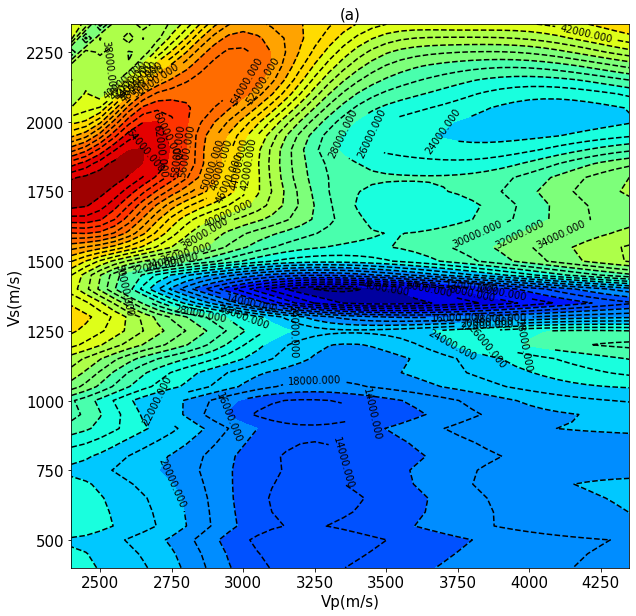

In [ ]:
import numpy  as np
import matplotlib.pyplot as plt
import matplotlib as mpl

font_size = 15
x = np.arange(2400,4400,model_variation_step)
y = np.arange(400, 2400,model_variation_step)
X,Y = np.meshgrid(x,y)


z_vp_vs_FFT_Z1_list = torch.Tensor(z_vp_vs_FFT_Z1_list).cpu()

z_vp_vs_FFT_Z1 = np.array(z_vp_vs_FFT_Z1_list)
z_vp_vs_FFT_Z1.shape = (len(x),len(y))
z_vp_vs_FFT_Z1 = np.mat(z_vp_vs_FFT_Z1).T

plt.figure(figsize=(10,10))
plt.subplot(111)
plt.contourf(X, Y, z_vp_vs_FFT_Z1, 20,cmap='jet')
A = plt.contour(X, Y, z_vp_vs_FFT_Z1, 40,colors='black', linestyles=("dashed"),linewidth=.01)
plt.title("(a)",size = font_size)
plt.yticks(fontproperties = 'Times New Roman', size = font_size) 
plt.xticks(fontproperties = 'Times New Roman', size = font_size) 
plt.clabel(A, inline=True, fontsize=10, fmt="%0.3f")
plt.ylabel('Vs(m/s)', size =  font_size )
plt.xlabel('Vp(m/s)', size = font_size  )

In [ ]:
vs_true = torch.ones(50,50)*400
vs_true[20:30,20:30] = 1380;
vs_tensor = torch.reshape(vs_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)



vp_init  = torch.ones(50,50)*2400
rho_init  = torch.ones(50,50)*0.5

vp_max = 2400 + 2000
rho_max = 500 + 2000
index = 0


vp_tensor_list = []
rho_tensor_list = []
x_list = []
y_list = []

for vp_variation in range (2400,vp_max,model_variation_step):
    for rho_variation in range (500,rho_max,model_variation_step):
        vp_init  = torch.ones(50,50)*2400
        rho_init  = torch.ones(50,50)*0.5
        vp_init[20:30,20:30] = vp_variation;
        rho_init[20:30,20:30] = rho_variation/1000;

        vp_init = torch.reshape(vp_init,(1,nz,nx)).type(dtype=torch.float32).to(device)
        rho_init = torch.reshape(rho_init,(1,nz,nx)).type(dtype=torch.float32).to(device)

        vp_tensor_list.append(vp_init)
        rho_tensor_list.append(rho_init)
        x_list.append(vp_variation)
        y_list.append(rho_variation)

z_vp_rho_FFT_Z1_list = []


loss_func1          = LogLoss(500,1.03)

for step in track(range(len(vp_tensor_list))):
    vp_init = vp_tensor_list[step]
    rho_init = rho_tensor_list[step]

    forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=4, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)


    vx_save, vz_save, \
    txx_save, tzz_save, txz_save, \
    segment_ytPred_x_init,segment_ytPred_z_init,avg_regularizer,\
    vp_tensor_out,vs_tensor_out,rho_tensor_out = \
    forward_rnn(\
    vp_tensor = vp_init,\
    vs_tensor = vs_tensor,\
    rho_tensor= rho_init,\
    segment_wavelet=wavelet)
    shots_init= torch.cat((segment_ytPred_x_init.reshape(1, len(xs),len(t), len(xr)),segment_ytPred_z_init.reshape(1, len(xs),len(t), len(xr))),dim=0)
    A,B,C,D,loss_FFT_Z1 = loss_func1(shots_init, shots_true)
    print(loss_FFT_Z1)
    z_vp_rho_FFT_Z1_list.append(loss_FFT_Z1)



        

using log information as misfit


Output()

tensor(0.0506, device='cuda:0')

tensor(0.0433, device='cuda:0')

tensor(0.0372, device='cuda:0')

tensor(0.0320, device='cuda:0')

tensor(0.0276, device='cuda:0')

tensor(0.0238, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0178, device='cuda:0')

tensor(0.0154, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0115, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0064, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0047, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0487, device='cuda:0')

tensor(0.0416, device='cuda:0')

tensor(0.0357, device='cuda:0')

tensor(0.0306, device='cuda:0')

tensor(0.0263, device='cuda:0')

tensor(0.0226, device='cuda:0')

tensor(0.0195, device='cuda:0')

tensor(0.0168, device='cuda:0')

tensor(0.0144, device='cuda:0')

tensor(0.0124, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0079, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0469, device='cuda:0')

tensor(0.0400, device='cuda:0')

tensor(0.0341, device='cuda:0')

tensor(0.0292, device='cuda:0')

tensor(0.0250, device='cuda:0')

tensor(0.0215, device='cuda:0')

tensor(0.0184, device='cuda:0')

tensor(0.0158, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0117, device='cuda:0')

tensor(0.0100, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0452, device='cuda:0')

tensor(0.0384, device='cuda:0')

tensor(0.0327, device='cuda:0')

tensor(0.0279, device='cuda:0')

tensor(0.0238, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0174, device='cuda:0')

tensor(0.0149, device='cuda:0')

tensor(0.0128, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.0093, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0436, device='cuda:0')

tensor(0.0369, device='cuda:0')

tensor(0.0314, device='cuda:0')

tensor(0.0267, device='cuda:0')

tensor(0.0227, device='cuda:0')

tensor(0.0193, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0120, device='cuda:0')

tensor(0.0102, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0420, device='cuda:0')

tensor(0.0355, device='cuda:0')

tensor(0.0300, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0216, device='cuda:0')

tensor(0.0183, device='cuda:0')

tensor(0.0156, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0112, device='cuda:0')

tensor(0.0095, device='cuda:0')

tensor(0.0081, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0406, device='cuda:0')

tensor(0.0341, device='cuda:0')

tensor(0.0288, device='cuda:0')

tensor(0.0243, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0174, device='cuda:0')

tensor(0.0147, device='cuda:0')

tensor(0.0125, device='cuda:0')

tensor(0.0105, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0391, device='cuda:0')

tensor(0.0328, device='cuda:0')

tensor(0.0276, device='cuda:0')

tensor(0.0232, device='cuda:0')

tensor(0.0196, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0139, device='cuda:0')

tensor(0.0117, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(0.0083, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0377, device='cuda:0')

tensor(0.0316, device='cuda:0')

tensor(0.0265, device='cuda:0')

tensor(0.0222, device='cuda:0')

tensor(0.0186, device='cuda:0')

tensor(0.0157, device='cuda:0')

tensor(0.0131, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0077, device='cuda:0')

tensor(0.0065, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0364, device='cuda:0')

tensor(0.0304, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0212, device='cuda:0')

tensor(0.0177, device='cuda:0')

tensor(0.0148, device='cuda:0')

tensor(0.0124, device='cuda:0')

tensor(0.0104, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0060, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0352, device='cuda:0')

tensor(0.0292, device='cuda:0')

tensor(0.0243, device='cuda:0')

tensor(0.0203, device='cuda:0')

tensor(0.0169, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0117, device='cuda:0')

tensor(0.0097, device='cuda:0')

tensor(0.0081, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0339, device='cuda:0')

tensor(0.0281, device='cuda:0')

tensor(0.0233, device='cuda:0')

tensor(0.0194, device='cuda:0')

tensor(0.0161, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0091, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0062, device='cuda:0')

tensor(0.0051, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0328, device='cuda:0')

tensor(0.0270, device='cuda:0')

tensor(0.0224, device='cuda:0')

tensor(0.0185, device='cuda:0')

tensor(0.0153, device='cuda:0')

tensor(0.0126, device='cuda:0')

tensor(0.0104, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0047, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0316, device='cuda:0')

tensor(0.0260, device='cuda:0')

tensor(0.0214, device='cuda:0')

tensor(0.0177, device='cuda:0')

tensor(0.0146, device='cuda:0')

tensor(0.0120, device='cuda:0')

tensor(0.0098, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0306, device='cuda:0')

tensor(0.0251, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0169, device='cuda:0')

tensor(0.0139, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0093, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0061, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0295, device='cuda:0')

tensor(0.0241, device='cuda:0')

tensor(0.0197, device='cuda:0')

tensor(0.0161, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(7.8024e-05, device='cuda:0')

tensor(7.0015e-05, device='cuda:0')

tensor(8.6130e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0285, device='cuda:0')

tensor(0.0233, device='cuda:0')

tensor(0.0190, device='cuda:0')

tensor(0.0154, device='cuda:0')

tensor(0.0126, device='cuda:0')

tensor(0.0102, device='cuda:0')

tensor(0.0082, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(6.4689e-05, device='cuda:0')

tensor(4.2834e-05, device='cuda:0')

tensor(4.7828e-05, device='cuda:0')

tensor(7.5703e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0276, device='cuda:0')

tensor(0.0224, device='cuda:0')

tensor(0.0182, device='cuda:0')

tensor(0.0148, device='cuda:0')

tensor(0.0120, device='cuda:0')

tensor(0.0097, device='cuda:0')

tensor(0.0078, device='cuda:0')

tensor(0.0062, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(6.8456e-05, device='cuda:0')

tensor(2.9985e-05, device='cuda:0')

tensor(2.1717e-05, device='cuda:0')

tensor(3.9046e-05, device='cuda:0')

tensor(7.8153e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0267, device='cuda:0')

tensor(0.0216, device='cuda:0')

tensor(0.0175, device='cuda:0')

tensor(0.0142, device='cuda:0')

tensor(0.0114, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(9.1713e-05, device='cuda:0')

tensor(3.3517e-05, device='cuda:0')

tensor(9.2817e-06, device='cuda:0')

tensor(1.3796e-05, device='cuda:0')

tensor(4.2786e-05, device='cuda:0')

tensor(9.2706e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0258, device='cuda:0')

tensor(0.0209, device='cuda:0')

tensor(0.0168, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(5.5561e-05, device='cuda:0')

tensor(1.2187e-05, device='cuda:0')

tensor(1.3152e-06, device='cuda:0')

tensor(1.8058e-05, device='cuda:0')

tensor(5.8180e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0250, device='cuda:0')

tensor(0.0201, device='cuda:0')

tensor(0.0162, device='cuda:0')

tensor(0.0130, device='cuda:0')

tensor(0.0104, device='cuda:0')

tensor(0.0083, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0052, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(9.8520e-05, device='cuda:0')

tensor(3.2479e-05, device='cuda:0')

tensor(3.1573e-06, device='cuda:0')

tensor(5.0915e-06, device='cuda:0')

tensor(3.3443e-05, device='cuda:0')

tensor(8.4112e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0242, device='cuda:0')

tensor(0.0194, device='cuda:0')

tensor(0.0156, device='cuda:0')

tensor(0.0125, device='cuda:0')

tensor(0.0100, device='cuda:0')

tensor(0.0079, device='cuda:0')

tensor(0.0062, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(7.2637e-05, device='cuda:0')

tensor(2.1355e-05, device='cuda:0')

tensor(5.4194e-06, device='cuda:0')

tensor(1.9495e-05, device='cuda:0')

tensor(5.8920e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0235, device='cuda:0')

tensor(0.0188, device='cuda:0')

tensor(0.0150, device='cuda:0')

tensor(0.0120, device='cuda:0')

tensor(0.0095, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(5.8287e-05, device='cuda:0')

tensor(2.0957e-05, device='cuda:0')

tensor(1.7825e-05, device='cuda:0')

tensor(4.3476e-05, device='cuda:0')

tensor(9.3424e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0228, device='cuda:0')

tensor(0.0182, device='cuda:0')

tensor(0.0145, device='cuda:0')

tensor(0.0115, device='cuda:0')

tensor(0.0091, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(5.4127e-05, device='cuda:0')

tensor(3.0404e-05, device='cuda:0')

tensor(3.9425e-05, device='cuda:0')

tensor(7.5939e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0221, device='cuda:0')

tensor(0.0176, device='cuda:0')

tensor(0.0140, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(5.9422e-05, device='cuda:0')

tensor(4.8407e-05, device='cuda:0')

tensor(6.9056e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0214, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0084, device='cuda:0')

tensor(0.0065, device='cuda:0')

tensor(0.0051, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(7.2885e-05, device='cuda:0')

tensor(7.4081e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0208, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0130, device='cuda:0')

tensor(0.0103, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(9.3655e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0202, device='cuda:0')

tensor(0.0160, device='cuda:0')

tensor(0.0126, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(0.0077, device='cuda:0')

tensor(0.0060, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0196, device='cuda:0')

tensor(0.0155, device='cuda:0')

tensor(0.0121, device='cuda:0')

tensor(0.0095, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0191, device='cuda:0')

tensor(0.0150, device='cuda:0')

tensor(0.0117, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0185, device='cuda:0')

tensor(0.0145, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0088, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0180, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0175, device='cuda:0')

tensor(0.0137, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0082, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0103, device='cuda:0')

tensor(0.0079, device='cuda:0')

tensor(0.0061, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0128, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(0.0076, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0161, device='cuda:0')

tensor(0.0124, device='cuda:0')

tensor(0.0096, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0156, device='cuda:0')

tensor(0.0121, device='cuda:0')

tensor(0.0093, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0152, device='cuda:0')

tensor(0.0117, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0052, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0148, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0144, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0084, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0047, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Vp(m/s)')

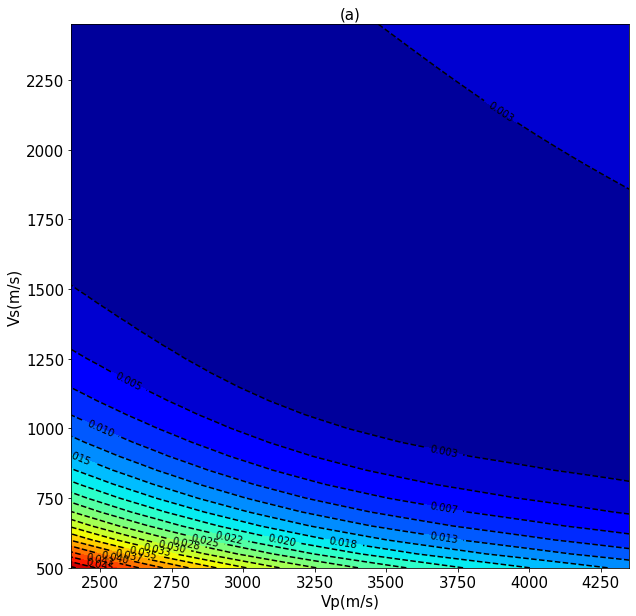

In [ ]:
font_size = 15
x = np.arange(2400,4400,model_variation_step)
y = np.arange(500, 2500,model_variation_step)
X,Y = np.meshgrid(x,y)

z_vp_rho_FFT_Z1_list = torch.Tensor(z_vp_rho_FFT_Z1_list).cpu()

z_vp_rho_FFT_Z1       = np.array(z_vp_rho_FFT_Z1_list)
z_vp_rho_FFT_Z1.shape = (len(x),len(y))
z_vp_rho_FFT_Z1       = np.mat(z_vp_rho_FFT_Z1).T

plt.figure(figsize=(10,10))
plt.subplot(111)
plt.contourf(X, Y, z_vp_rho_FFT_Z1, 20,cmap='jet')
A = plt.contour(X, Y, z_vp_rho_FFT_Z1, 20,colors='black', linestyles=("dashed"),linewidth=.01)
plt.title("(a)",size = font_size)
plt.yticks(fontproperties = 'Times New Roman', size = font_size) 
plt.xticks(fontproperties = 'Times New Roman', size = font_size) 
plt.clabel(A, inline=True, fontsize=10, fmt="%0.3f")
plt.ylabel('Vs(m/s)', size =  font_size )
plt.xlabel('Vp(m/s)', size = font_size  )

In [ ]:
vp_true = torch.ones(50,50)*2400
vp_true[20:30,20:30] = 3800;
vp_tensor = torch.reshape(vp_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)



vs_init  = torch.ones(50,50)*400
rho_init  = torch.ones(50,50)*0.5

vs_max = 400 + 2000
rho_max = 500 + 2000
index = 0


vs_tensor_list = []
rho_tensor_list = []
x_list = []
y_list = []

for vs_variation in range (400,vs_max,model_variation_step):
    for rho_variation in range (500,rho_max,model_variation_step):
        vs_init  = torch.ones(50,50)*400
        rho_init  = torch.ones(50,50)*0.5
        vs_init[20:30,20:30] = vs_variation;
        rho_init[20:30,20:30] = rho_variation/1000;

        vs_init = torch.reshape(vs_init,(1,nz,nx)).type(dtype=torch.float32).to(device)
        rho_init = torch.reshape(rho_init,(1,nz,nx)).type(dtype=torch.float32).to(device)

        vs_tensor_list.append(vs_init)
        rho_tensor_list.append(rho_init)
        x_list.append(vs_variation)
        y_list.append(rho_variation)

z_vs_rho_FFT_Z1_list = []


costFunc1 = torch.nn.L1Loss(reduction='sum')

for step in track(range(len(vs_tensor_list))):
    vs_init = vs_tensor_list[step]
    rho_init = rho_tensor_list[step]

    forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=4, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)


    vx_save, vz_save, \
    txx_save, tzz_save, txz_save, \
    segment_ytPred_x_init,segment_ytPred_z_init,avg_regularizer,\
    vp_tensor_out,vs_tensor_out,rho_tensor_out = \
    forward_rnn(\
    vp_tensor = vp_tensor,\
    vs_tensor = vs_init,\
    rho_tensor= rho_init,\
    segment_wavelet=wavelet)
    shots_init= torch.cat((segment_ytPred_x_init.reshape(1, len(xs),len(t), len(xr)),segment_ytPred_z_init.reshape(1, len(xs),len(t), len(xr))),dim=0)
    A,B,C,D,loss_FFT_Z1 = loss_func1(shots_init, shots_true)
    print(loss_FFT_Z1)
    z_vs_rho_FFT_Z1_list.append(loss_FFT_Z1)



        

Output()

tensor(0.0260, device='cuda:0')

tensor(0.0211, device='cuda:0')

tensor(0.0171, device='cuda:0')

tensor(0.0139, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0060, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0260, device='cuda:0')

tensor(0.0211, device='cuda:0')

tensor(0.0171, device='cuda:0')

tensor(0.0139, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0060, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0260, device='cuda:0')

tensor(0.0210, device='cuda:0')

tensor(0.0171, device='cuda:0')

tensor(0.0139, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0091, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0259, device='cuda:0')

tensor(0.0210, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0138, device='cuda:0')

tensor(0.0112, device='cuda:0')

tensor(0.0091, device='cuda:0')

tensor(0.0073, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0047, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0259, device='cuda:0')

tensor(0.0210, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0138, device='cuda:0')

tensor(0.0112, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.0073, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0047, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0258, device='cuda:0')

tensor(0.0209, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0137, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0258, device='cuda:0')

tensor(0.0209, device='cuda:0')

tensor(0.0169, device='cuda:0')

tensor(0.0137, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0258, device='cuda:0')

tensor(0.0208, device='cuda:0')

tensor(0.0169, device='cuda:0')

tensor(0.0137, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0257, device='cuda:0')

tensor(0.0208, device='cuda:0')

tensor(0.0168, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0088, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0257, device='cuda:0')

tensor(0.0208, device='cuda:0')

tensor(0.0168, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.0088, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0256, device='cuda:0')

tensor(0.0207, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0256, device='cuda:0')

tensor(0.0207, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0256, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(8.6515e-05, device='cuda:0')

tensor(8.6194e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(9.6286e-05, device='cuda:0')

tensor(6.3549e-05, device='cuda:0')

tensor(6.2845e-05, device='cuda:0')

tensor(8.9250e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(7.5846e-05, device='cuda:0')

tensor(4.2829e-05, device='cuda:0')

tensor(4.1670e-05, device='cuda:0')

tensor(6.7613e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(5.9066e-05, device='cuda:0')

tensor(2.5535e-05, device='cuda:0')

tensor(2.3926e-05, device='cuda:0')

tensor(4.9291e-05, device='cuda:0')

tensor(9.7591e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(4.6908e-05, device='cuda:0')

tensor(1.2940e-05, device='cuda:0')

tensor(1.0762e-05, device='cuda:0')

tensor(3.5520e-05, device='cuda:0')

tensor(8.3124e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(4.0747e-05, device='cuda:0')

tensor(6.2965e-06, device='cuda:0')

tensor(3.5333e-06, device='cuda:0')

tensor(2.7631e-05, device='cuda:0')

tensor(7.4634e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(4.0997e-05, device='cuda:0')

tensor(5.9920e-06, device='cuda:0')

tensor(2.6454e-06, device='cuda:0')

tensor(2.6158e-05, device='cuda:0')

tensor(7.2558e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0024, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(4.7355e-05, device='cuda:0')

tensor(1.1761e-05, device='cuda:0')

tensor(7.8161e-06, device='cuda:0')

tensor(3.0707e-05, device='cuda:0')

tensor(7.6293e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(5.8961e-05, device='cuda:0')

tensor(2.2756e-05, device='cuda:0')

tensor(1.8154e-05, device='cuda:0')

tensor(4.0316e-05, device='cuda:0')

tensor(8.5100e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(7.5013e-05, device='cuda:0')

tensor(3.8121e-05, device='cuda:0')

tensor(3.2788e-05, device='cuda:0')

tensor(5.4101e-05, device='cuda:0')

tensor(9.8146e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(9.4853e-05, device='cuda:0')

tensor(5.7225e-05, device='cuda:0')

tensor(5.0987e-05, device='cuda:0')

tensor(7.1478e-05, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0132, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(7.9501e-05, device='cuda:0')

tensor(7.2321e-05, device='cuda:0')

tensor(9.1809e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(9.6224e-05, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0001, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0253, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0069, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0027, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0002, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.0088, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.0088, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0028, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0256, device='cuda:0')

tensor(0.0207, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0036, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0022, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0256, device='cuda:0')

tensor(0.0207, device='cuda:0')

tensor(0.0168, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0257, device='cuda:0')

tensor(0.0208, device='cuda:0')

tensor(0.0169, device='cuda:0')

tensor(0.0137, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0015, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0019, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0258, device='cuda:0')

tensor(0.0209, device='cuda:0')

tensor(0.0169, device='cuda:0')

tensor(0.0137, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.0073, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0047, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0259, device='cuda:0')

tensor(0.0210, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0138, device='cuda:0')

tensor(0.0112, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.0073, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0047, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0023, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0011, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0003, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0004, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0005, device='cuda:0')

tensor(0.0006, device='cuda:0')

tensor(0.0007, device='cuda:0')

tensor(0.0008, device='cuda:0')

tensor(0.0009, device='cuda:0')

tensor(0.0010, device='cuda:0')

tensor(0.0012, device='cuda:0')

tensor(0.0013, device='cuda:0')

tensor(0.0014, device='cuda:0')

tensor(0.0016, device='cuda:0')

tensor(0.0017, device='cuda:0')

tensor(0.0018, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0021, device='cuda:0')

tensor(0.0022, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Vp(m/s)')

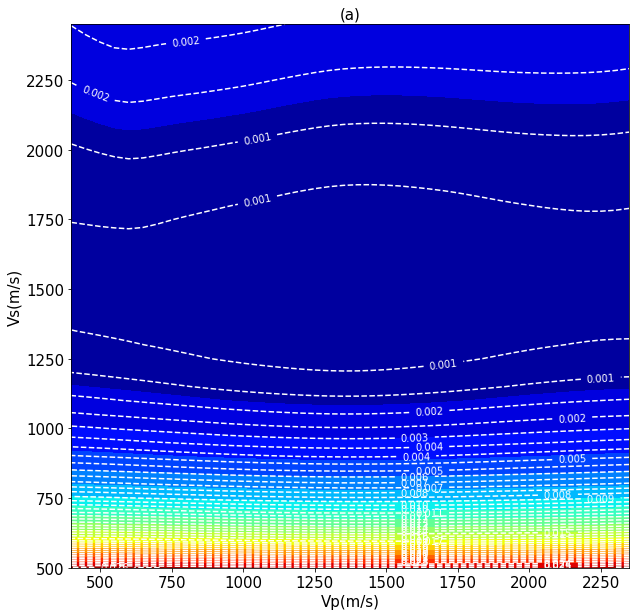

In [ ]:
font_size = 15
x = np.arange(400,2400,model_variation_step)
y = np.arange(500, 2500,model_variation_step)
X,Y = np.meshgrid(x,y)

z_vs_rho_FFT_Z1_list = torch.Tensor(z_vs_rho_FFT_Z1_list).cpu()

z_vs_rho_FFT_Z1       = np.array(z_vs_rho_FFT_Z1_list)
z_vs_rho_FFT_Z1.shape = (len(x),len(y))
z_vs_rho_FFT_Z1       = np.mat(z_vs_rho_FFT_Z1).T

plt.figure(figsize=(10,10))
plt.subplot(111)
plt.contourf(X, Y, z_vs_rho_FFT_Z1, 20,cmap='jet')
A = plt.contour(X, Y, z_vs_rho_FFT_Z1 , 50,colors='white', linestyles=("dashed"),linewidth=.01)
plt.title("(a)",size = font_size)
plt.yticks(fontproperties = 'Times New Roman', size = font_size) 
plt.xticks(fontproperties = 'Times New Roman', size = font_size) 
plt.clabel(A, inline=True, fontsize=10, fmt="%0.3f")
plt.ylabel('Vs(m/s)', size =  font_size )
plt.xlabel('Vp(m/s)', size = font_size  )

In [ ]:
torch.save(z_vs_rho_FFT_Z1,'./Objective_function_results/z_vs_rho_FFT_Z1_GP_2022.pt')
torch.save(z_vp_rho_FFT_Z1,'./Objective_function_results/z_vp_rho_FFT_Z1_GP_2022.pt')
torch.save(z_vp_vs_FFT_Z1, './Objective_function_results/z_vp_vs_FFT_Z1_GP_2022.pt')